# Определение перспективного тарифа для телеком компании

## Описание проекта
По индивидуальным характеристикам пользователей тарифов, определить, какой тариф перспективнее для телеком компании

### Описание тарифов

|Характеристика|Смарт|Ультра|
|------|------|------|
Ежемесячная плата|550|1950|
Лимит звонков(минуты)|500|3000|
Лимит сообщений|50|1000|
Лимит интернет трафика(Гб)|15|30|
1 дополнительная минута разгоовра|3|1|
1 дополнительное сообщение|3|1|
1 дополнительный Гб интрнет трафика|200|150|

## Описание данных

#### 1) Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

#### 2) Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

#### 3) Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

#### 4) Таблица internet (информация об интернет-сессиях):

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

#### 5) Таблица tariffs (информация о тарифах):

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
---------------------------------------------------------------------------------------------------------------------------------------

## Содержание

#### Часть 1. Изучение общей информации:
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)
    
#### Часть 2. Анализ:
* [1. Агрегирование тарифов интернета, звонков, сообщений по месяцам, пользователям](#1-bullet)
* [2. Получение суммарного дохода пользователей, анализ значений в разрезе тарифов](#2-bullet)

#### Часть 3. Проверка гипотез:
* [1. Средние значения ежемесячной платы у тарифов Смарт и Ультра разные на уровне значимости 95%](#1-bullet)
* [2. Средние значения длительности телефонных разговоров у тарифов Смарт и Ультра разные на уровне значимости 95%](#2-bullet)
* [3. Средние значения интернет объемов трафика у тарифов Смарт и Ультра разные на уровне значимости 95%](#3-bullet)
* [4. Средние значения кол-ва сообщений у тарифов Смарт и Ультра одинаковые на уровне значимости 95%](#4-bullet)
* [5. Средние значения общей выручки у тарифов Смарт и Ультра разные на уровне значимости 95%](#5-bullet)
* [6. Средние значения выручки в Москве и других городах у тарифов Смарт и Ультра одинаковые на уровне значимости 95%](#6-bullet)

#### Часть 4. Выводы:
* [1. "Смарт" расходует меньше трафика](#1-bullet)
* [2. Разброс значений у пользователей "Смарт" меньше](#2-bullet)
* [3. В сумме тариф "Смарт" приносит больше дохода](#3-bullet)
* [4. Суммарная продолжительность звонков, Кол-во звонков, Объем израсходованного трафика - распределены нормально у обоих тарифов](#4-bullet)
* [5. Кол-во сообщений, Выручка - распределены по-другому у обоих тарифов](#5-bullet)

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

from collections import defaultdict
from itertools import groupby
import gc
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_calls = pd.read_csv('datasets/calls.csv')
df_internet = pd.read_csv('datasets/internet.csv')
df_mess = pd.read_csv('datasets/messages.csv')
df_tar = pd.read_csv('datasets/tariffs.csv').set_index('tariff_name')
df_user = pd.read_csv('datasets/users.csv')

In [3]:
def _convert_types(df, print_report = True):
    ''' Преобразует типы данных '''
    df_c = df.copy()
    # проходим по каждой колонке
    for col in df_c.columns:
        try:
            # меняем тип на дату
            df_c[col] = df_c[col].astype('datetime64')
        except:            
            try:
                # приводим к инту, если возможно
                _val = df_c[col]
                _val_int = _val.astype(np.int32)
                if (_val == _val_int).all():
                    df_c[col] = df_c[col].astype('int')
                else:
                    df_c[col] = df_c[col].astype('float')
            except:
                try:
                    # bool --> float
                    df_c[col] = df_c[col].astype('float')
                except:
                    # удаляем пропуски, приводим к нижнему регистру
                    df_c[col] = df_c[col].str.lower().str.strip()
    if print_report:
        print('Отчет по типам данных\n')
        D_types = defaultdict(list)
        for k, v in df_c.dtypes.items():
            D_types[v].append(k)

        for k, v in D_types.items():
            print('Тип == {}. Колонки:'.format(k))
            for i, column in enumerate(v):
                print('\t{}) {}'.format(i+1, column))
            
            
    return df_c

#### преобразуем типы

In [4]:
print('\nТелефон\n-----------------')
df_calls = _convert_types(df_calls, print_report = True)
print('\nИнтернет\n-----------------')
df_internet = _convert_types(df_internet, print_report = True)
print('\nСообщения\n-----------------')
df_mess = _convert_types(df_mess, print_report = True)


Телефон
-----------------
Отчет по типам данных

Тип == float64. Колонки:
	1) id
	2) duration
Тип == datetime64[ns]. Колонки:
	1) call_date
Тип == int32. Колонки:
	1) user_id

Интернет
-----------------
Отчет по типам данных

Тип == int32. Колонки:
	1) Unnamed: 0
	2) user_id
Тип == float64. Колонки:
	1) id
	2) mb_used
Тип == datetime64[ns]. Колонки:
	1) session_date

Сообщения
-----------------
Отчет по типам данных

Тип == float64. Колонки:
	1) id
Тип == datetime64[ns]. Колонки:
	1) message_date
Тип == int32. Колонки:
	1) user_id


### Шаг 2. Подготовьте данные

#### переименовываем колонки

In [5]:
df_internet = df_internet.drop('Unnamed: 0', 1).rename({'session_date':'date', 'mb_used':'used'}, axis = 1)
df_calls = df_calls.rename({'call_date':'date', 'duration':'used'}, axis = 1)
df_mess = df_mess.rename({'message_date':'date'}, axis = 1)

report_dtypes = pd.concat([df_calls.dtypes.to_frame('Телефон'),\
                           df_internet.dtypes.to_frame('Интернет'),\
                           df_mess.dtypes.to_frame('Сообщения')], 1).sort_index()

In [6]:
report_dtypes


,Телефон,Интернет,Сообщения
date,datetime64[ns],datetime64[ns],datetime64[ns]
id,float64,float64,float64
used,float64,float64,NaN
user_id,int32,int32,int32


#### оставляем пользователей, которые есть во всех выборках

In [7]:
users_to_use = set.intersection(set(df_internet['user_id']), set(df_calls['user_id']), set(df_mess['user_id']))

df_internet = df_internet[df_internet['user_id'].isin(users_to_use)]
df_calls = df_calls[df_calls['user_id'].isin(users_to_use)]
df_mess = df_mess[df_mess['user_id'].isin(users_to_use)]

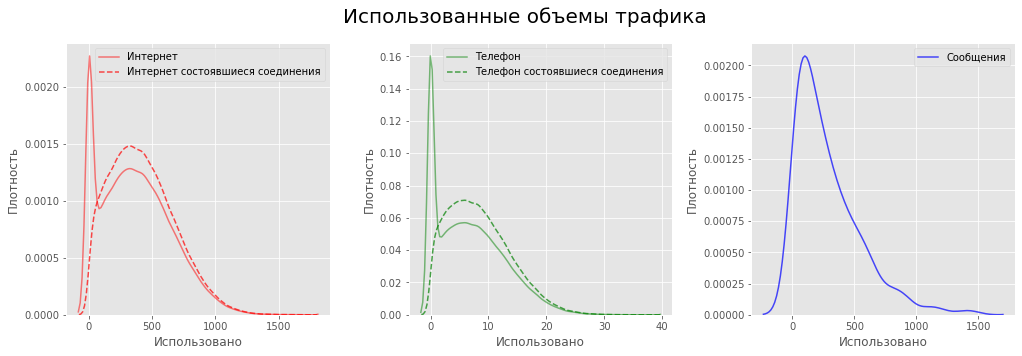

In [8]:
plt.figure(figsize = (17, 5))
plt.suptitle('Использованные объемы трафика', fontsize = 20)

plt.subplot(1, 3, 1)
sns.kdeplot(df_internet['used'], color = 'red', alpha = .5)
sns.kdeplot(df_internet['used'][df_internet['used']!=0], color = 'red', alpha = .7, linestyle ='--')
plt.legend(['Интернет', 'Интернет состоявшиеся соединения'])
plt.xlabel('Использовано')
plt.ylabel('Плотность')

plt.subplot(1, 3, 2)
sns.kdeplot(df_calls['used'], color = 'green', alpha = .5)
sns.kdeplot(df_calls['used'][df_calls['used']!=0], color = 'green', alpha = .7, linestyle ='--')

plt.legend(['Телефон', 'Телефон состоявшиеся соединения'])
plt.xlabel('Использовано')
plt.ylabel('Плотность')

plt.subplot(1, 3, 3)
sns.kdeplot(df_mess.groupby('user_id').size(), color = 'blue', alpha = .7, label = 'Сообщения')
plt.xlabel('Использовано')
plt.ylabel('Плотность')

plt.subplots_adjust(wspace = .3)
plt.show()

#### Несостоявшиеся соединения заменим на np.nan

In [9]:
df_internet['used'] = df_internet['used'].apply(lambda x: x if x!=0 else np.nan)
df_calls['used'] = df_calls['used'].apply(lambda x: x if x!=0 else np.nan)

#### Ежемесячные платы пользователей

In [10]:
# извлекаем из даты месяц
for df in [df_mess, df_calls, df_internet]:
    df['month'] = df['date'].dt.month
    
# округляем использованные минуты и мегабайты 
df_calls['used'] = np.ceil(df_calls['used'])
df_internet['used'] = np.ceil(df_internet['used'])

df_agg = ((df_calls.groupby(['user_id', 'month'])['used'].agg({'sum', 'count'})\
                    .rename(columns = {'sum':'Суммарная продолжительность звонков', 'count':'Кол-во звонков'}))\
            .join(df_mess.groupby(['user_id', 'month']).size().to_frame('Кол-во сообщений'))\
            .join(df_internet.groupby(['user_id', 'month'])['used'].sum().to_frame('Объем израсходованного трафика'))).reset_index()

# коллекция строк
rows = []

# группироуем данные по пользователям и месяцам
for (_user_id, _month), _subdf in df_agg.groupby(['user_id', 'month']):

    # выясняем тарифный план пользователя
    user_tariff = df_tar.loc[df_user[df_user['user_id'] == _user_id]['tariff']]

    # ежемесячныая плата
    monthly_fee = user_tariff['rub_monthly_fee'].values[0]

    # лимит звонков
    surplus_calls = _subdf['Суммарная продолжительность звонков'].values[0] - user_tariff['minutes_included'].values[0]

    # лимит сообщений
    surplus_mess = _subdf['Кол-во сообщений'].values[0] - user_tariff['messages_included'][0]

    # лимит интернет трафика
    surplus_internet = _subdf['Объем израсходованного трафика'].values[0] - user_tariff['mb_per_month_included'].values[0]    

    # если лимиты превышаются, то значения округляем в верхнюю сторону и считаем дополнительные ежемесячные выплаты    
    total_calls = np.ceil(surplus_calls*user_tariff['rub_per_minute'].values[0]) if surplus_calls>0 else 0  
    total_mess = np.ceil(surplus_mess*user_tariff['rub_per_message'].values[0]) if surplus_mess>0 else 0    
    total_internet = np.ceil(surplus_internet/1024)*user_tariff['rub_per_gb'].values[0] if surplus_internet>0 else 0

    # коллекционируем пользователя, месяц, сумму выплат
    rows.append((_user_id, _month,  monthly_fee, total_calls, total_internet, total_mess,\
                 monthly_fee+total_calls+total_internet+total_mess))

_income_monthly = pd.DataFrame(rows)
_income_monthly.columns = ['user_id', 'month', 'Ежемесячная плата', 'Телефон', 'Интернет', 'Сообщения', 'Выручка']
    
df_montly_by_user = df_agg.set_index(['user_id', 'month'])\
                          .join(_income_monthly.set_index(['user_id', 'month']))\
                          .reset_index().rename(columns = {'month':'Месяц'})  

In [11]:
df_montly_by_user

,user_id,Месяц,Кол-во звонков,Суммарная продолжительность звонков,Кол-во сообщений,Объем израсходованного трафика,Ежемесячная плата,Телефон,Интернет,Сообщения,Выручка
0,1000,5,17,159.0,22.0,2256.0,1950,0.0,0.0,0.0,1950.0
1,1000,6,28,172.0,60.0,23257.0,1950,0.0,0.0,0.0,1950.0
2,1000,7,41,340.0,75.0,14016.0,1950,0.0,0.0,0.0,1950.0
3,1000,8,42,408.0,81.0,14070.0,1950,0.0,0.0,0.0,1950.0
4,1000,9,46,466.0,57.0,14581.0,1950,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...
2688,1498,10,30,247.0,42.0,20604.0,550,0.0,1200.0,0.0,1750.0
2689,1499,9,8,70.0,11.0,1848.0,550,0.0,0.0,0.0,550.0
2690,1499,10,44,449.0,48.0,17809.0,550,0.0,600.0,0.0,1150.0
2691,1499,11,62,612.0,59.0,17984.0,550,336.0,600.0,27.0,1513.0


## Шаг 3. Проанализируйте данные

#### Суммарные платы пользователей

In [12]:
payments = ['Ежемесячная плата', 'Телефон', 'Интернет', 'Сообщения', 'Выручка']
df_total_report = df_user.set_index('user_id')\
                    .join(df_montly_by_user.groupby('user_id')[payments].sum())
df_total_report = df_total_report[df_total_report[payments].notna().all(1)]\
                    .rename(columns = {'age': 'Возраст', 'churn_date':'Дата оттока',\
                                       'city' : 'Город', 'first_name':'Имя', 'last_name':'Фамилия',\
                                       'reg_date':'Дата регистрации', 'tariff':'Тариф'})
df_total_report['Тариф'] = df_total_report['Тариф'].map({'ultra':'Ультра', 'smart':'Смарт'})

In [13]:
df_total_report

,Возраст,Дата оттока,Город,Имя,Фамилия,Дата регистрации,Тариф,Ежемесячная плата,Телефон,Интернет,Сообщения,Выручка
user_id,,,,,,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,Ультра,15600.0,0.0,0.0,0.0,15600.0
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,Смарт,3850.0,0.0,3400.0,0.0,7250.0
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,Ультра,9750.0,0.0,0.0,0.0,9750.0
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,Ультра,15600.0,0.0,0.0,0.0,15600.0
1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,Смарт,6600.0,3225.0,0.0,99.0,9924.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,Ультра,9750.0,0.0,1800.0,0.0,11550.0
1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,Смарт,6600.0,1548.0,20400.0,3.0,28551.0
1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,Смарт,1650.0,135.0,1000.0,0.0,2785.0


In [14]:
def _plot_kde_boxplot_by_category(df_total_report, by, to_compare, **kwargs):
    
    ''' Рисует плотность, ящик с усами для признака to_plot, сгруппированного по by'''
    
    plt.figure(**kwargs)
    plt.suptitle(to_compare, fontsize = 20)

    plt.subplot(1, 2, 1)
    df_total_report.groupby(by)[to_compare].apply(lambda x: sns.kdeplot(x))
    plt.ylabel('Плотность')
    plt.xlabel(to_compare)

    plt.subplot(1, 2, 2)
    sns.boxplot(data = df_total_report, x = by, y = to_compare)

In [15]:
def _compare_means_in_two_groups(df_total_report, by, to_compare, alpha):
    
    '''
    Тестирует гипотезу о равенстве средних значений в двух выборках на уровне значимости alpha
        1) если распределения нормальные, использует тест Стьюдента
        2) если нет - бутстреп
    '''
    unique_groups = np.unique(df_total_report[by])
    D = {}
    for group in unique_groups:
        D[group] = df_total_report[df_total_report[by] == group][to_compare]
    
    if all([stats.normaltest(val)[1]>alpha for val in D.values()]):
        print('Используем тест T-тест Стьюдента')
        results = []
        groups = list(D.keys())
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                k1, k2 = groups[i], groups[j]
                res = stats.ttest_ind(D[k1], D[k2])[1]                
                results.append((k1, k2, 'Одинаковые' if res<alpha else 'Разные'))
        return results
    else:
        bt_means_df = pd.DataFrame()
        for k, v in D.items():
            low, high = np.percentile(np.mean(np.random.choice(v, (10000, 10)), 1), [alpha/2, 1-alpha/2])
            bt_means_df.loc[k, 'low'] = low
            bt_means_df.loc[k, 'high'] = high
        groups = bt_means_df.index
        results = []
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                k1, k2 = groups[i], groups[j]
                low1, high1 = bt_means_df.loc[k1]
                low2, high2 = bt_means_df.loc[k2]
                if ((low1<low2) & (high1<low2)) | ((low2<low1) & (high2<low1)):
                    results.append((k1, k2, 'Разные'))
                else:
                    results.append((k1, k2, 'Одинаковые'))  
        return results

Средние в двух группах | alpha = 0.05:
	Смарт <--> Ультра | Одинаковые


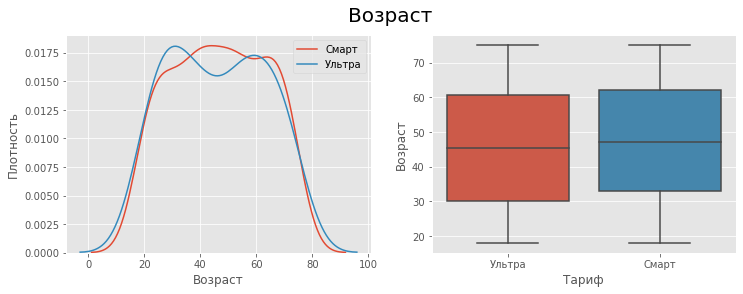

In [16]:
by = 'Тариф'
to_compare = 'Возраст'
alpha = .05

_plot_kde_boxplot_by_category(df_total_report, by = by, to_compare = to_compare, figsize = (12, 4))

print('Средние в двух группах | alpha = {}:'.format(alpha))
for i, result in enumerate(_compare_means_in_two_groups(df_total_report, by = by, to_compare = to_compare, alpha =alpha)):
    print('\t{} <--> {} | {}'.format(result[0], result[1], result[2]))

In [17]:
def _plot_bar(churn_by_tariff, horisontal, name):
    
    ''' Рисует столбчатую диаграмму признака to_plot, сгруппированного по by'''
    plt.title(name)
    if horisontal:
        sns.barplot(y = churn_by_tariff.index, x = churn_by_tariff.values,\
                    orient = 'h', palette = 'Set1', edgecolor = 'black')
        plt.ylabel('Категории')
        plt.xlabel('Кол-во/Доля')
    else:
        sns.barplot(x = churn_by_tariff.index, y = churn_by_tariff.values,\
                    orient = 'v', palette = 'Set1', edgecolor = 'black')
        plt.xlabel('Категории')
        plt.ylabel('Кол-во/Доля')
        

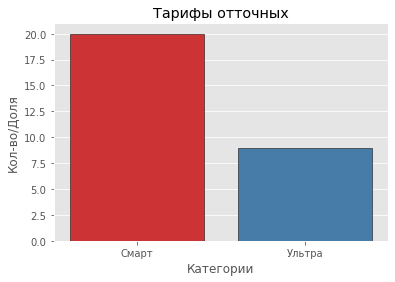

In [18]:
churn_by_tariff = df_total_report[df_total_report['Дата оттока'].notna()]['Тариф'].value_counts()
_plot_bar(churn_by_tariff, False, 'Тарифы отточных')

In [19]:
def _compare_proportions_in_tow_groups(set1, set2, alpha):    
    count = [sum(set1), sum(set2)]
    nobs = [len(set1), len(set2)]
    if proportions_ztest(count, nobs)[1] > alpha:
        return 'Разные'
    else:
        return 'Одинаковые'

Результат тестирования: доли Разные


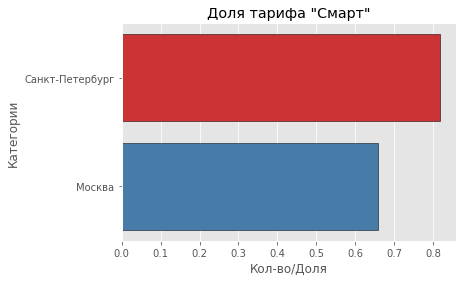

In [20]:
tariff_by_city = df_total_report.groupby(['Тариф', 'Город']).size().unstack(0)
tariff_by_city['Всего'] = tariff_by_city.sum(1)
tariff_by_city = tariff_by_city.fillna(0).sort_values('Всего', ascending = False)
tariff_by_city['Доля Смарт'] = tariff_by_city['Смарт'] / tariff_by_city['Всего']
tariff_by_city = tariff_by_city.drop(['Смарт', 'Ультра'], 1)

_plot_bar(tariff_by_city[tariff_by_city['Всего'] >= 20]['Доля Смарт'].sort_values(ascending = False), True, 'Доля тарифа "Смарт"')

set1 = df_total_report[df_total_report['Город'] == 'Москва']['Тариф'] == 'Смарт'
set2 = df_total_report[df_total_report['Город'] == 'Санкт-Петербург']['Тариф'] == 'Смарт'
print('Результат тестирования: доли {}'.format(_compare_proportions_in_tow_groups(set1, set2, alpha)))

In [21]:
df_total_report

,Возраст,Дата оттока,Город,Имя,Фамилия,Дата регистрации,Тариф,Ежемесячная плата,Телефон,Интернет,Сообщения,Выручка
user_id,,,,,,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,Ультра,15600.0,0.0,0.0,0.0,15600.0
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,Смарт,3850.0,0.0,3400.0,0.0,7250.0
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,Ультра,9750.0,0.0,0.0,0.0,9750.0
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,Ультра,15600.0,0.0,0.0,0.0,15600.0
1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,Смарт,6600.0,3225.0,0.0,99.0,9924.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,Ультра,9750.0,0.0,1800.0,0.0,11550.0
1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,Смарт,6600.0,1548.0,20400.0,3.0,28551.0
1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,Смарт,1650.0,135.0,1000.0,0.0,2785.0


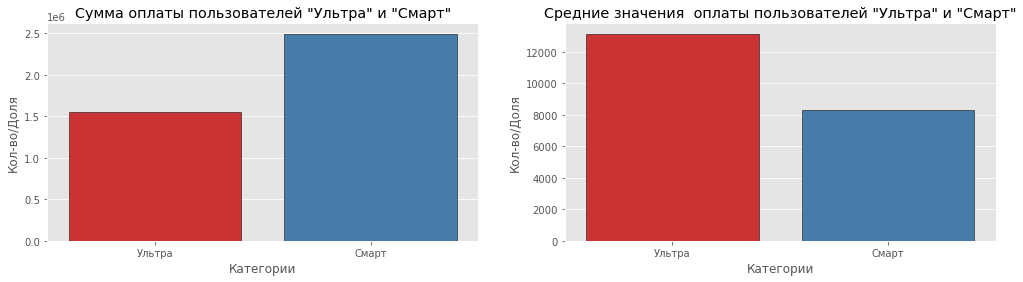

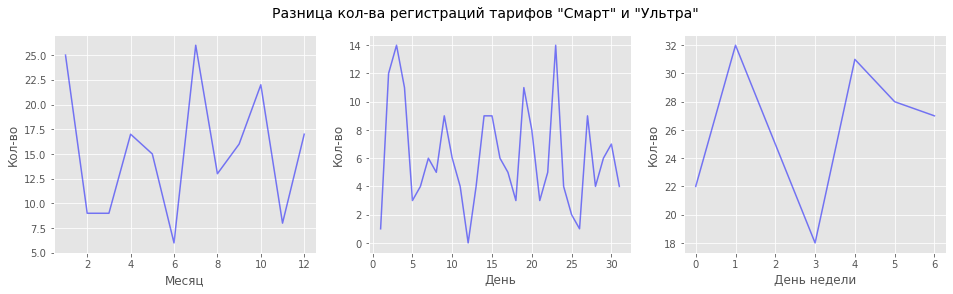

In [22]:
_sum = df_total_report.groupby('Тариф')['Выручка'].sum().loc[['Ультра', 'Смарт']]
_mean = df_total_report.groupby('Тариф')['Выручка'].mean().loc[['Ультра', 'Смарт']]

plt.figure(figsize = (17, 4))
ax1 = plt.subplot(1, 2, 1)
_plot_bar(_sum, False, 'Cумма оплаты пользователей "Ультра" и "Смарт"')
ax2 = plt.subplot(1, 2, 2)
_plot_bar(_mean, False, 'Средние значения  оплаты пользователей "Ультра" и "Смарт"')
plt.show()

fg = plt.figure()
fg.suptitle('Разница кол-ва регистраций тарифов "Смарт" и "Ультра"', fontsize = 14)

ax1 = plt.subplot(1, 3, 1)
pd.concat([df_total_report['Дата регистрации'].astype('datetime64').dt.month.to_frame('Месяц').astype(int),\
           df_total_report[['Тариф']]], 1)\
    .groupby(['Месяц', 'Тариф']).size().unstack().diff(axis = 1).abs()['Ультра']\
    .plot(ax = ax1, figsize = (16, 4), color ='blue', alpha = .5)
plt.ylabel('Кол-во')

ax2 = plt.subplot(1, 3, 2)
pd.concat([df_total_report['Дата регистрации'].astype('datetime64').dt.day.to_frame('День').astype(int),\
           df_total_report[['Тариф']]], 1)\
    .groupby(['День', 'Тариф']).size().unstack().diff(axis = 1).abs()['Ультра']\
    .plot(ax = ax2, figsize = (16, 4), color ='blue', alpha = .5)
plt.ylabel('Кол-во')


ax3 = plt.subplot(1, 3, 3)
pd.concat([df_total_report['Дата регистрации'].astype('datetime64').dt.dayofweek.to_frame('День недели').astype(int),\
           df_total_report[['Тариф']]], 1)\
    .groupby(['День недели', 'Тариф']).size().unstack().diff(axis = 1).abs()['Ультра']\
    .plot(ax = ax3, figsize = (16, 4), color ='blue', alpha = .5)
plt.ylabel('Кол-во')




plt.show()

In [23]:
df_total_report = df_total_report.replace({0:np.nan})

In [24]:
def _test_dist(dist, alpha):
    dist_names = ('Нормльное', 'Равномерное', 'Логнормаьное')
    mean, std = mean = dist.mean(), dist.std()
    alphas = np.array([stats.kstest(dist, 'norm')[1], (mean, std),\
                        stats.kstest(dist, 'uniform')[1], (mean, std),\
                        stats.kstest(np.log1p(dist), 'norm')[1]])
    res = np.argwhere(alphas>= alpha)
    if len(res)>0:
        return dist_names[res[0]]
    else:
        return 'Другое'
    

In [25]:

def _plot_distribution(x, alpha):
    
    if isinstance(x, pd.Series):
        arr = x.replace({0:np.nan}).dropna()
        q25, q75 = np.percentile(arr, [25, 75])
        iqr = q75-q25
        arr_iqr = arr[(arr>=q25-1.5*iqr) | (arr<=q75+1.5*iqr)]

        arr_iqr_log =arr_iqr.apply(np.log1p)

        plt.figure(figsize = (16, 4))
        plt.subplot(1, 3, 1)
        plt.hist(stats.norm.rvs(loc = arr_iqr.mean(), scale = arr_iqr.std(), size = 1000), density = 1, alpha = .6)
        plt.hist(arr_iqr, density = 1, alpha = .6)

        plt.title('Нормалльное | {} | alpha= {}'.format('Отклоняем' if stats.kstest(arr_iqr, 'norm',\
                                                                     args=(arr_iqr.mean(),\
                                                                           arr_iqr.std()))[1] <=alpha else 'Принимаем' ,alpha))
        plt.legend(['Выборка', 'Нормалльное'])

        plt.subplot(1, 3, 2)
        plt.hist(stats.norm.rvs(loc = arr_iqr_log.mean(), scale = arr_iqr_log.std(), size = 1000), density = 1, alpha = .6)
        plt.hist(arr_iqr_log, density = 1, alpha = .6)

        plt.title('Логнормалльное | {} | alpha = {}'\
                      .format('Отклоняем' if stats.kstest(arr_iqr_log, 'norm', args=(arr_iqr_log.mean(), \
                                                                      arr_iqr_log.std()))[1]<= alpha else'Принимаем', alpha))
        plt.legend(['Выборка', 'Логнормалльное'])

        plt.subplot(1, 3, 3)
        plt.hist(stats.uniform.rvs(loc = arr_iqr.min(), scale = arr_iqr.max(), size = 1000), density = 1, alpha = .6)
        plt.hist(arr_iqr, density = 1, alpha = .6)


        plt.title('Равномерное | {} | alpha = {}'.format('Отклоняем' if stats.kstest(arr_iqr, 'uniform',\
                                                                      args=(arr_iqr.min(),\
                                                                            arr_iqr.max()))[1]<=alpha else 'Принимаем',alpha))
        plt.legend(['Выборка', 'Равномерное'])

In [26]:

def _test_distribution(x, alpha):
    
    if isinstance(x, pd.Series):
        arr = x.replace({0:np.nan}).dropna()
        q25, q75 = np.percentile(arr, [25, 75])
        iqr = q75-q25
        arr_iqr = arr[(arr>=q25-1.5*iqr) | (arr<=q75+1.5*iqr)]
        arr_iqr_log =arr_iqr.apply(np.log1p)
        

        res1 = 'Нормалбьное | Отклоняем' if stats.kstest(arr_iqr, 'norm', args=(arr_iqr.mean(), arr_iqr.std()))[1] <=alpha else 'Нормалбьное | Принимаем' 
        res2 = 'Логнормальное | Отклоняем' if stats.kstest(arr_iqr_log, 'norm', args=(arr_iqr_log.mean(), arr_iqr_log.std()))[1]<= alpha else'Логнормальное | Принимаем'
        res3 = 'Раномерное | Отклоняем' if stats.kstest(arr_iqr, 'uniform', args=(arr_iqr.min(),arr_iqr.max()))[1]<=alpha else 'Равномерное | Принимаем'
        return (res1, res2, res3)

ВОЗРАСТ


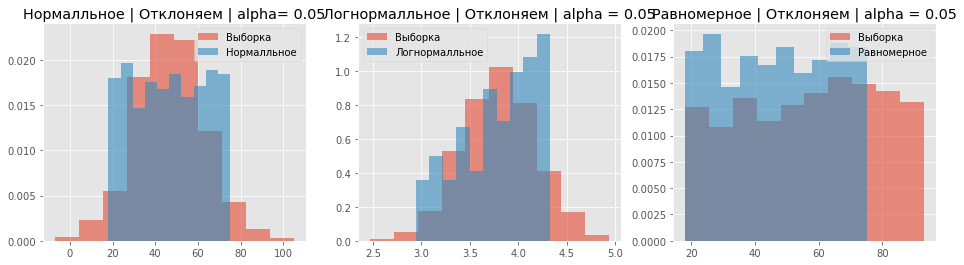

---------------------------------------------------------
ЕЖЕМЕСЯЧНАЯ ПЛАТА


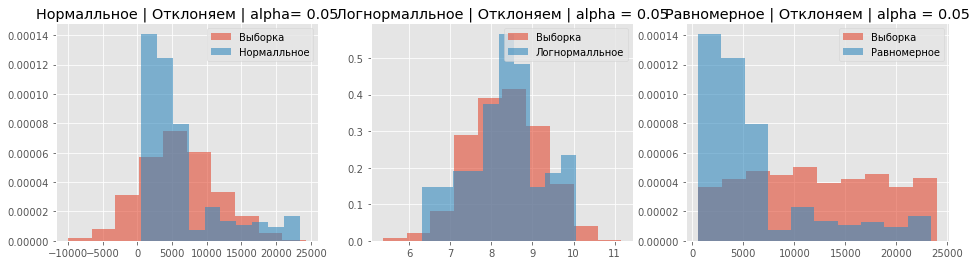

---------------------------------------------------------
ТЕЛЕФОН


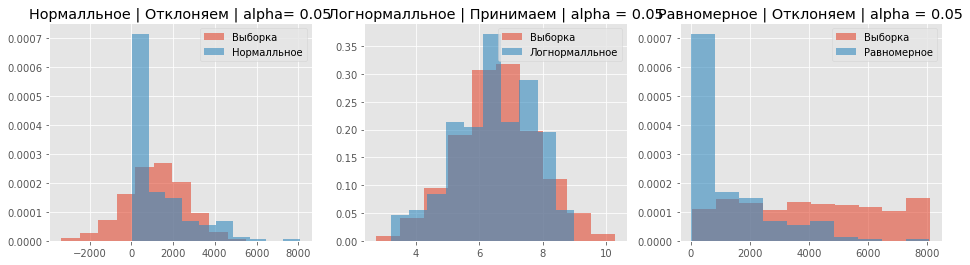

---------------------------------------------------------
ИНТЕРНЕТ


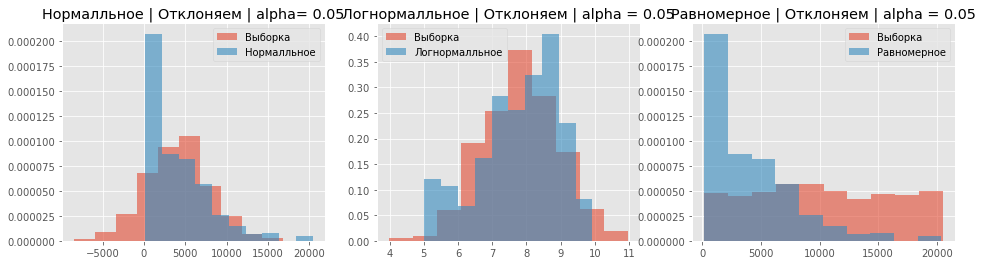

---------------------------------------------------------
СООБЩЕНИЯ


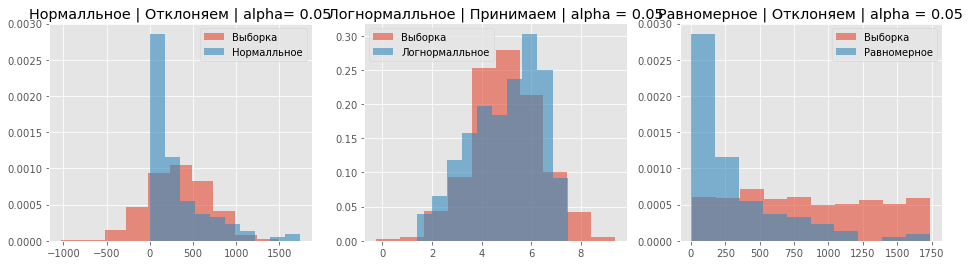

---------------------------------------------------------
ВЫРУЧКА


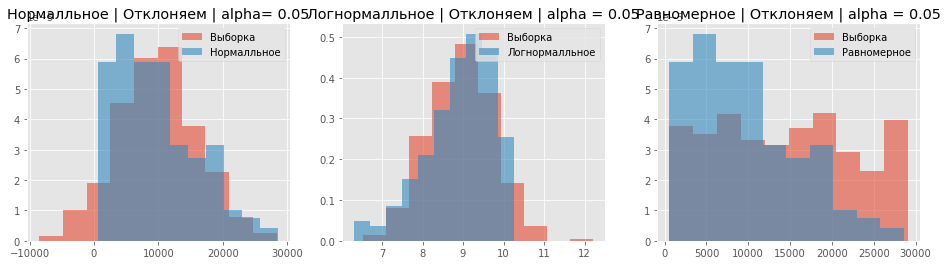

---------------------------------------------------------


In [27]:
for col in df_total_report.select_dtypes('number').columns:
    print(str.upper(col))   
    _plot_distribution(df_total_report[col], .05)
    plt.show()
    print('---------------------------------------------------------')

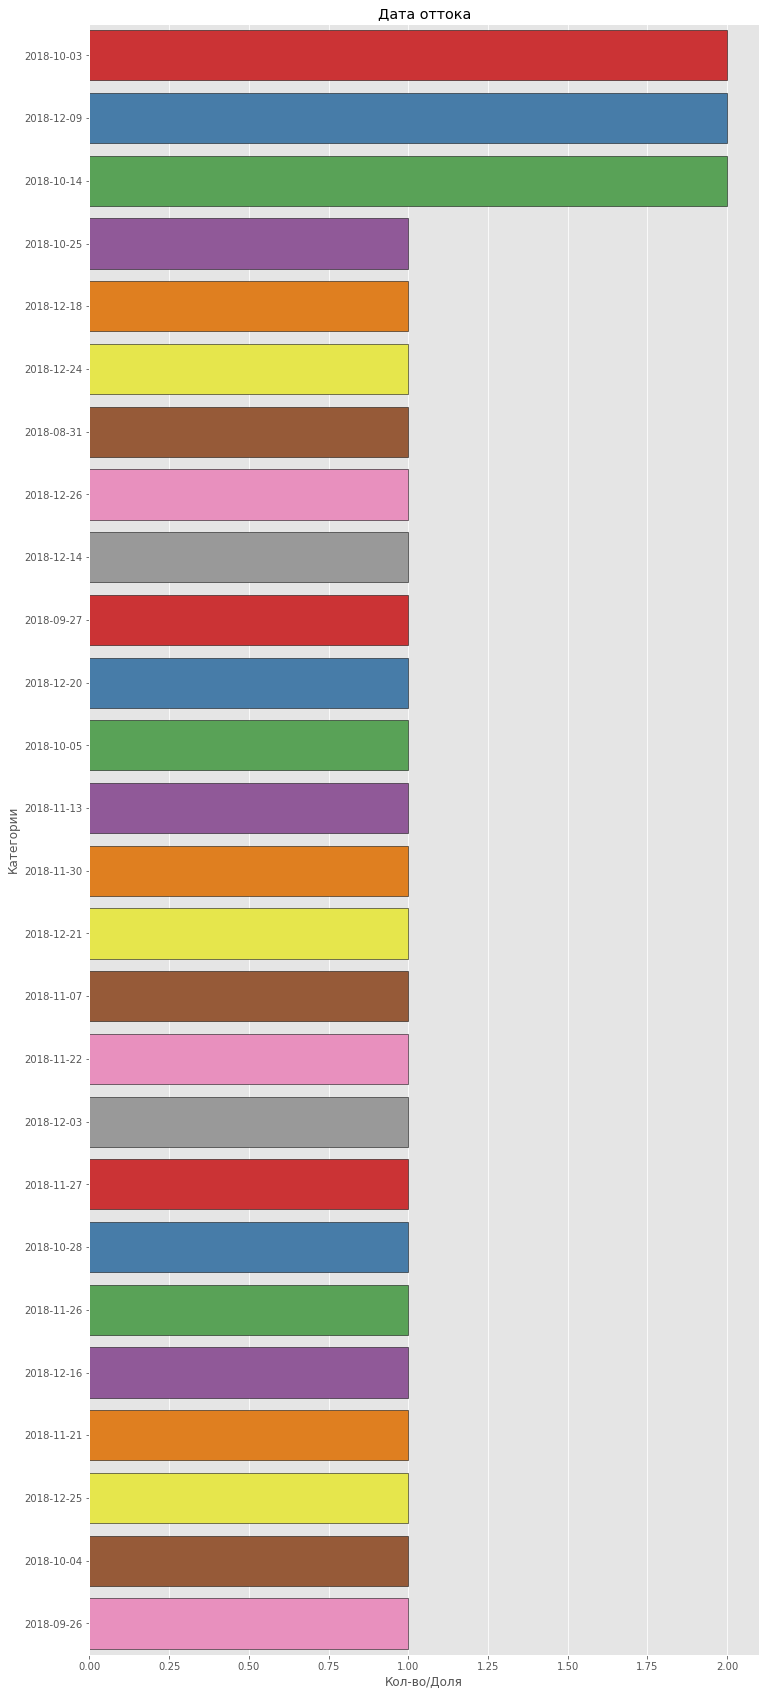

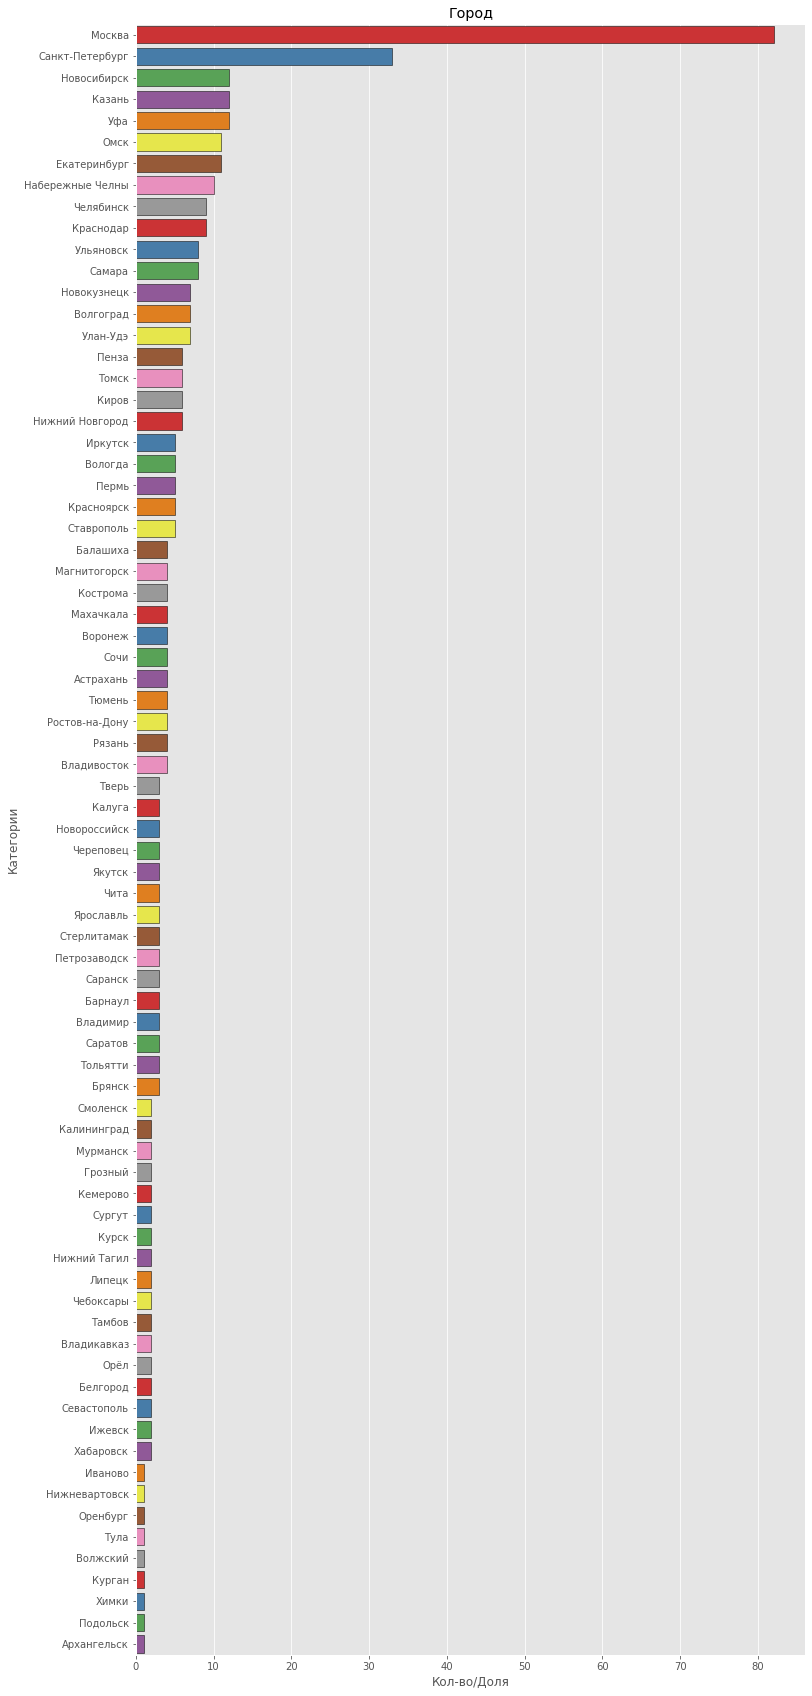

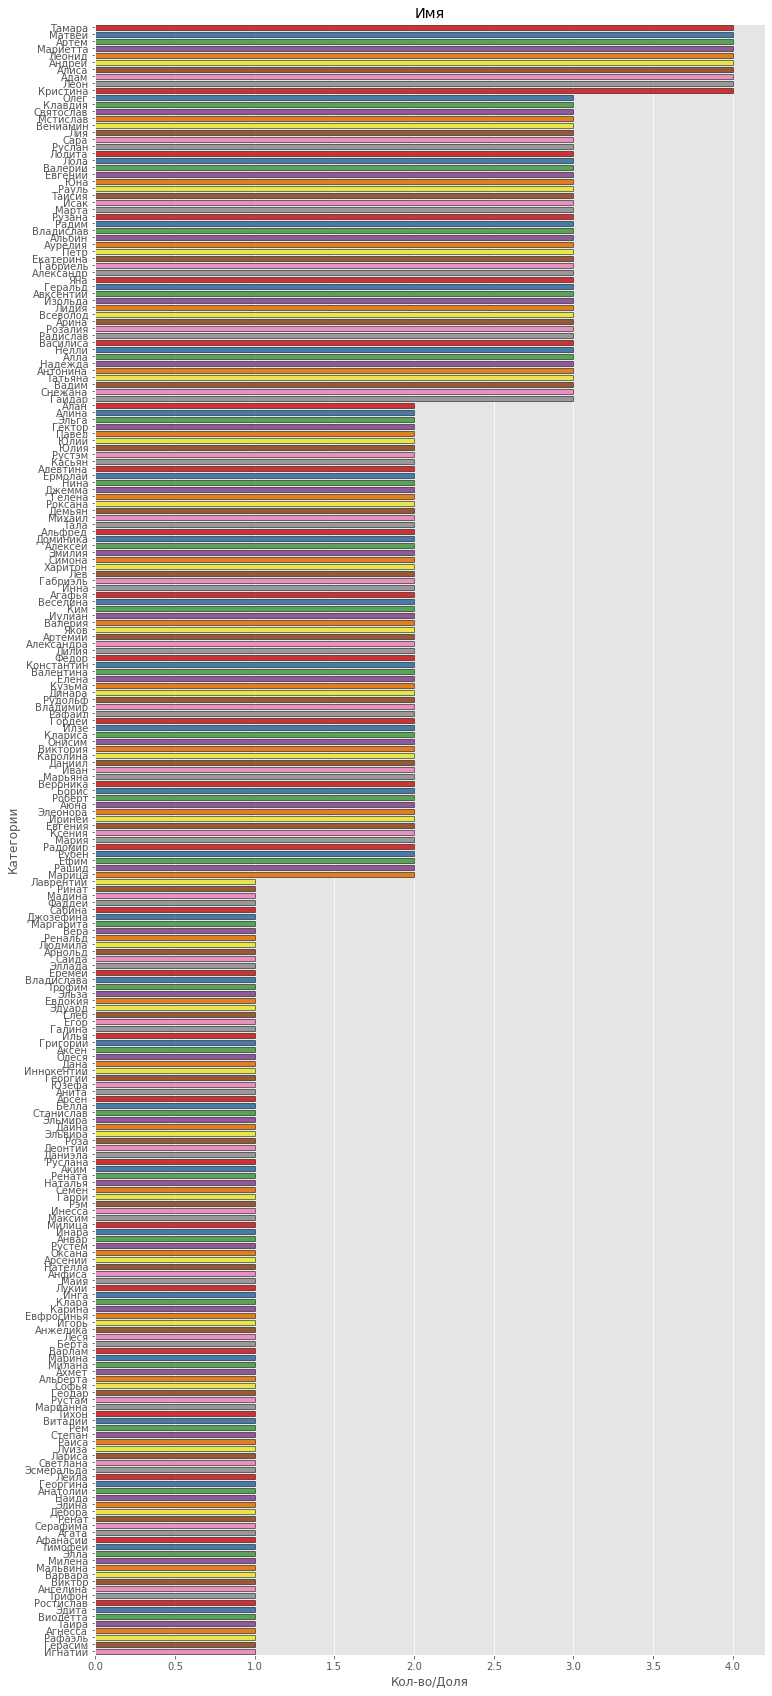

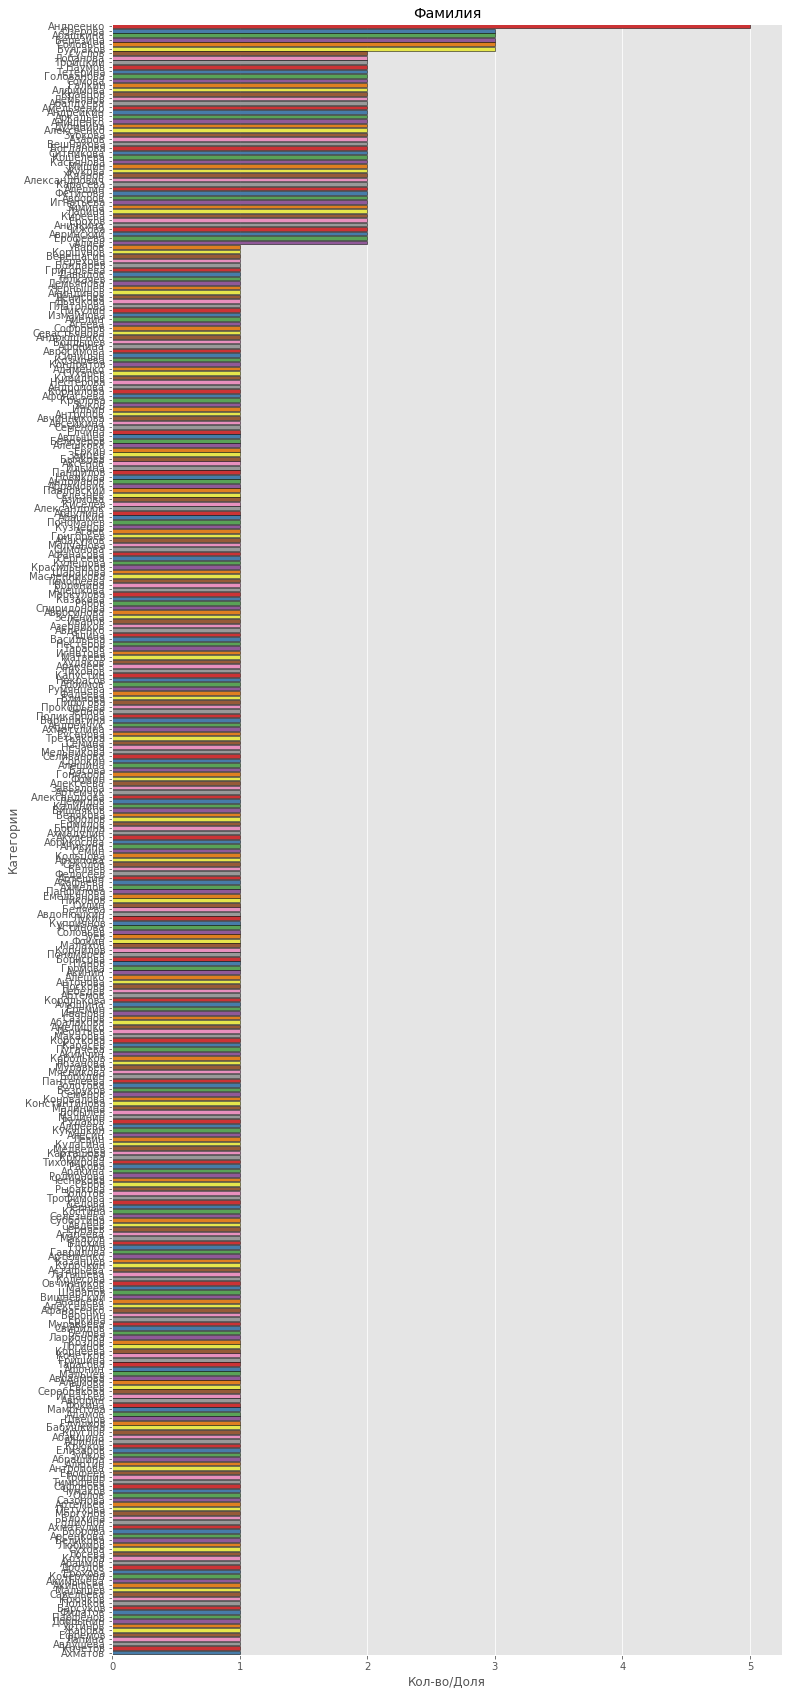

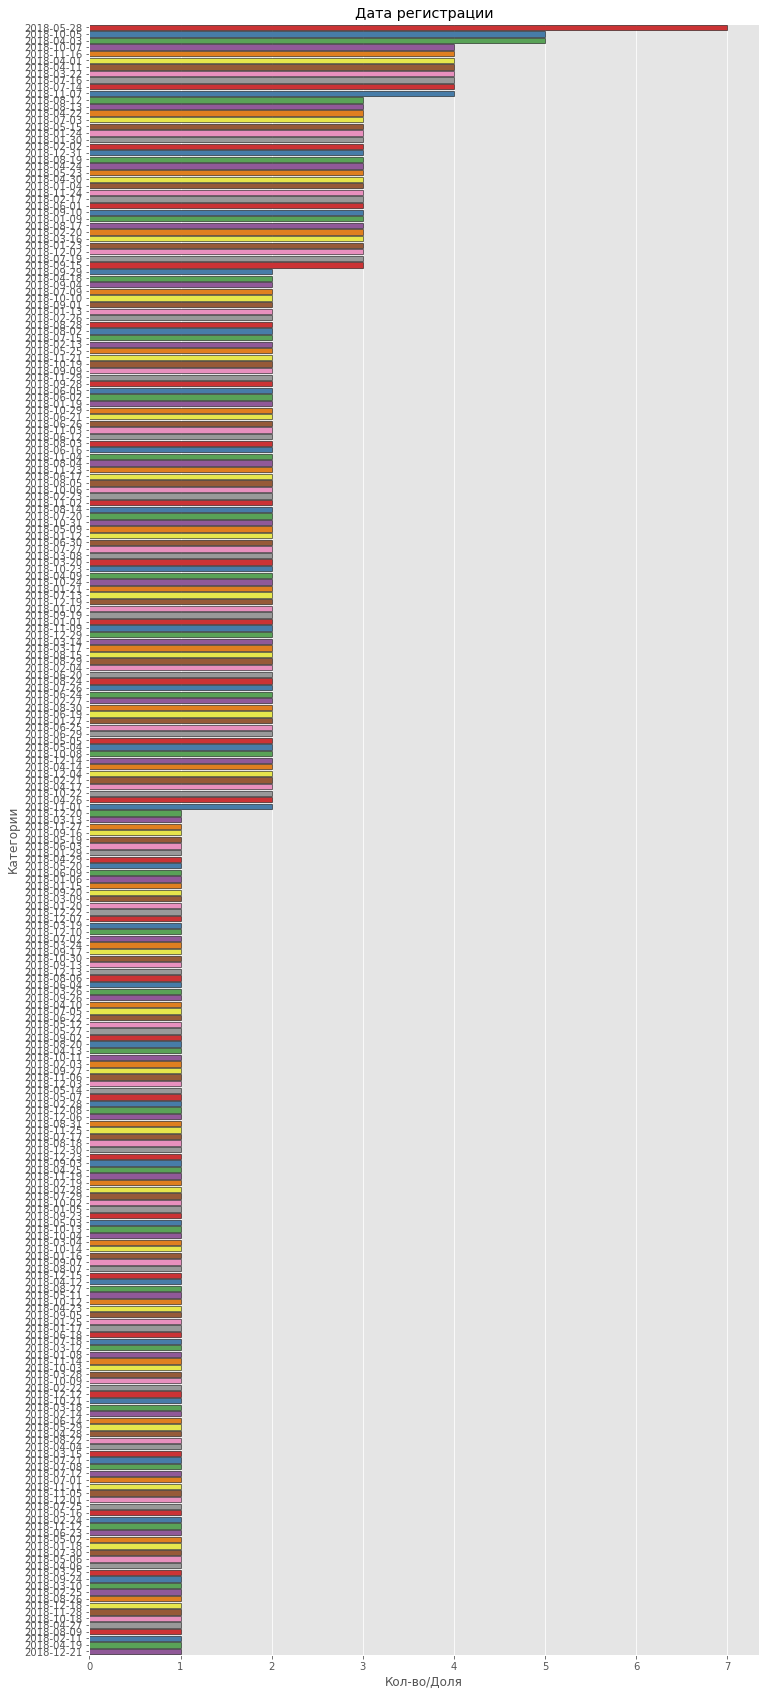

In [28]:
for col in df_total_report.select_dtypes(exclude = ['number']).columns[:-1]:
    counts = df_total_report[col].value_counts()
    plt.figure(figsize = (12, 30))
    _plot_bar(counts, True, col)
    plt.show()

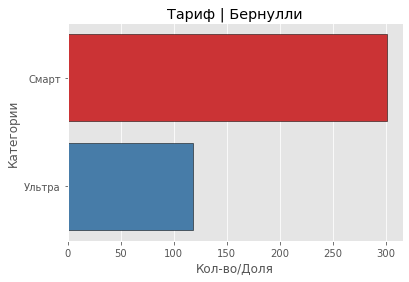

In [29]:
_plot_bar(df_total_report['Тариф'].value_counts(), True, 'Тариф | Бернулли')

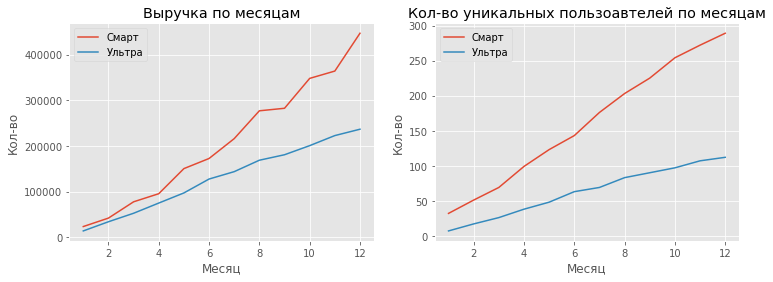

In [30]:
payments_ = pd.merge(df_montly_by_user,\
                                    df_user[['user_id', 'tariff']],\
                                    on = 'user_id', how ='inner')\
                               .rename(columns = {'tariff': 'Тариф'})

payments_by_month_tariff = payments_.groupby(['Тариф', 'Месяц']).sum().round().astype(int)['Выручка'].unstack(0)
payments_by_month_tariff.columns = ['Смарт', 'Ультра']

nuniqes_by_tar_month = payments_.groupby(['Тариф', 'Месяц'])['user_id'].nunique().unstack(0)
nuniqes_by_tar_month.columns = ['Смарт', 'Ультра']


ax1 = plt.subplot(1, 2, 1)
payments_by_month_tariff.plot(ax = ax1, figsize = (12, 4))
plt.ylabel('Кол-во')
plt.title('Выручка по месяцам')

ax2 = plt.subplot(1, 2, 2)
nuniqes_by_tar_month.plot(ax = ax2, figsize = (12, 4))
plt.ylabel('Кол-во')
plt.title('Кол-во уникальных пользоавтелей по месяцам')

plt.show()

In [31]:
df_monthly_by_tariff = pd.merge(df_montly_by_user, df_total_report.reset_index()[['user_id', 'Тариф']], on = 'user_id', how ='inner').drop('user_id', 1)

In [32]:
df_monthly_by_tariff = pd.concat([df_monthly_by_tariff['Тариф'], df_monthly_by_tariff.drop('Тариф', 1).astype(float)], 1)

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


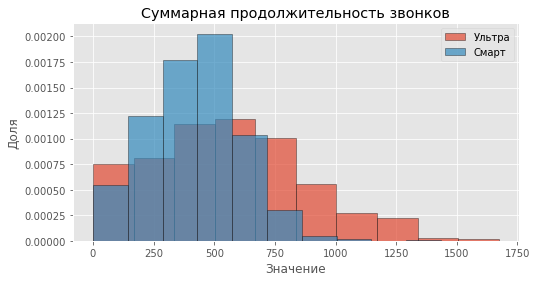

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


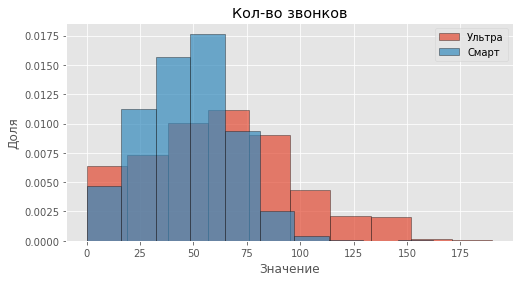

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


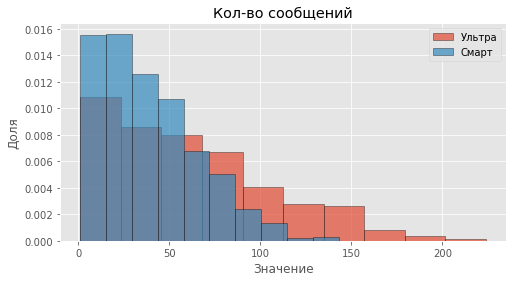

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


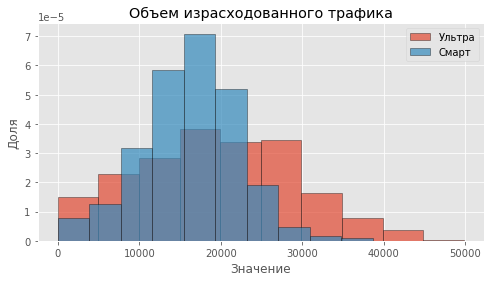

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


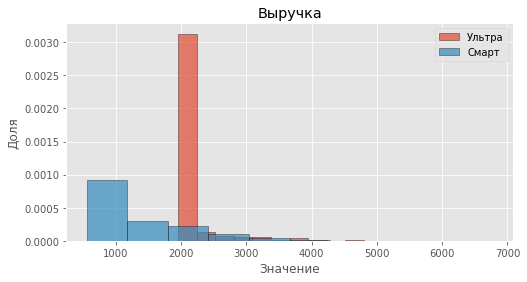

In [33]:
l_ = []
mask = df_monthly_by_tariff['Тариф'] == 'Ультра'
for col in ['Суммарная продолжительность звонков',
       'Кол-во звонков', 'Кол-во сообщений', 'Объем израсходованного трафика',
       'Выручка']:

    
    ax = plt.subplot(1, 1, 1)
    dist1 = df_monthly_by_tariff[mask][col]
    dist1.hist(density = 1, alpha = .7, ax = ax, edgecolor = 'black', figsize = (8, 4))
    print('Ультра')
    print(_test_distribution(dist1, alpha=.05))
    
    dist2 = df_monthly_by_tariff[~mask][col]
    dist2.hist(density = 1, alpha = .7, ax = ax, edgecolor = 'black', figsize = (8, 4))
    print('Смарт')
    print(_test_distribution(dist2, alpha=.05))
    
    plt.title(col)
    plt.xlabel('Значение')
    plt.ylabel('Доля')    
    plt.legend(['Ультра', 'Смарт'])
    plt.show() 
    
    l_.append((col, 'Ультра', _test_distribution(dist1, alpha=.05)))
    l_.append((col, 'Смарт', _test_distribution(dist2, alpha=.05)))

In [34]:
_D = defaultdict(list)
_df = pd.DataFrame.from_records(l_)
for i in _df.index:
    row = _df.loc[i]
    _D[row[2]].append((row[0], row[1]))

In [35]:
print('Распределения за все время')
for k, v in _D.items():
    print(k)
    for j, element in enumerate(v):
        print('\t{} {}'.format(j, element))
    print('--------------------------------------')

Распределения за все время
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
	0 ('Суммарная продолжительность звонков', 'Ультра')
	1 ('Суммарная продолжительность звонков', 'Смарт')
	2 ('Кол-во звонков', 'Ультра')
	3 ('Кол-во звонков', 'Смарт')
	4 ('Объем израсходованного трафика', 'Ультра')
	5 ('Объем израсходованного трафика', 'Смарт')
--------------------------------------
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
	0 ('Кол-во сообщений', 'Ультра')
	1 ('Кол-во сообщений', 'Смарт')
	2 ('Выручка', 'Ультра')
	3 ('Выручка', 'Смарт')
--------------------------------------


Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


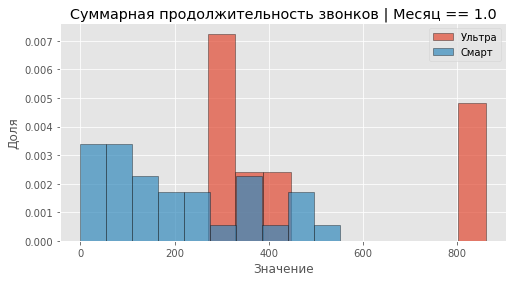

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')


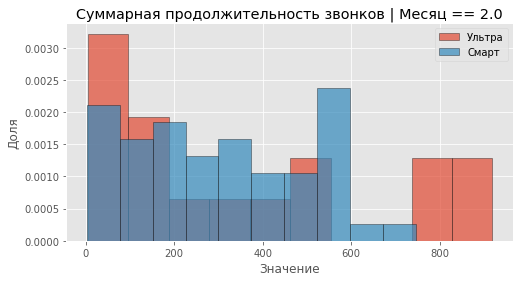

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Равномерное | Принимаем')


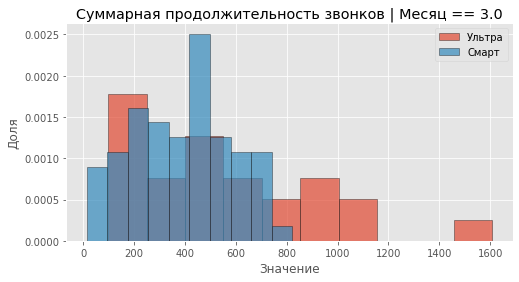

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


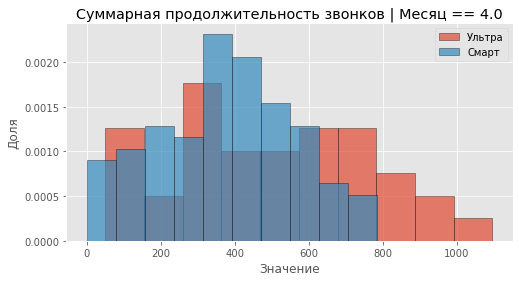

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


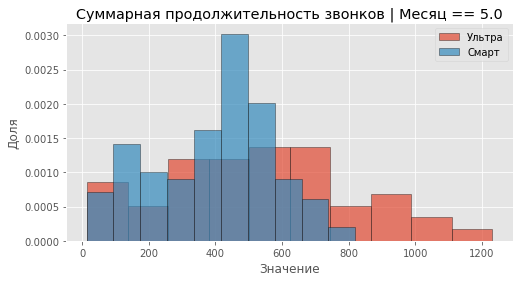

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


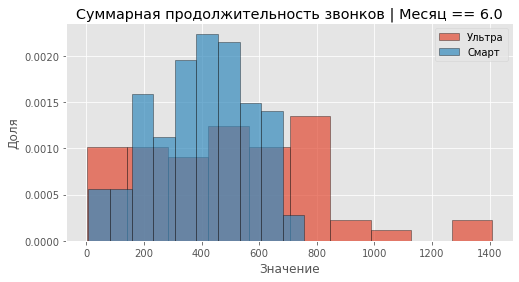

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


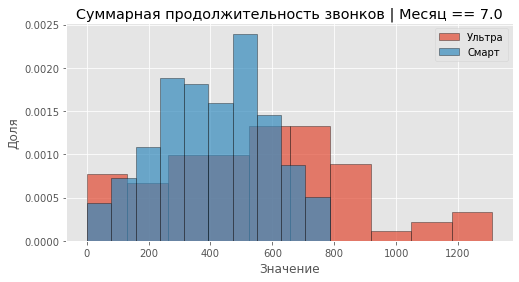

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


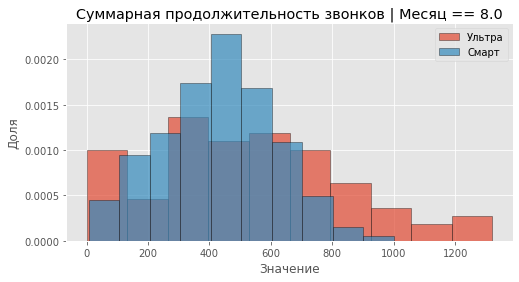

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


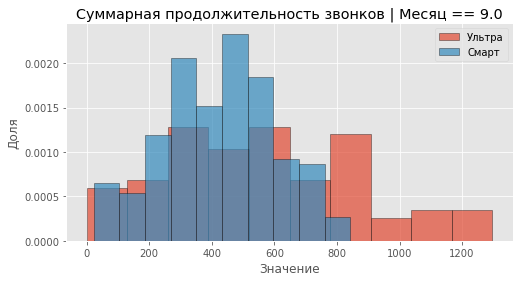

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


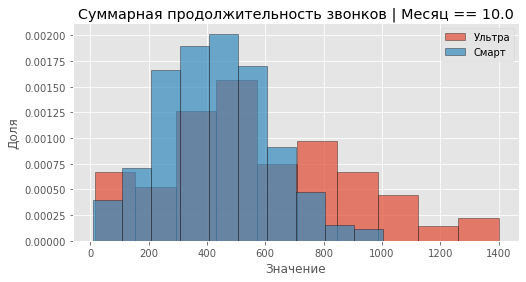

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


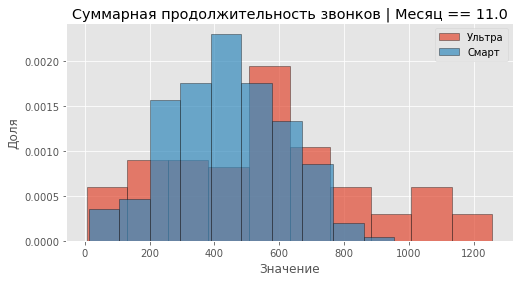

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


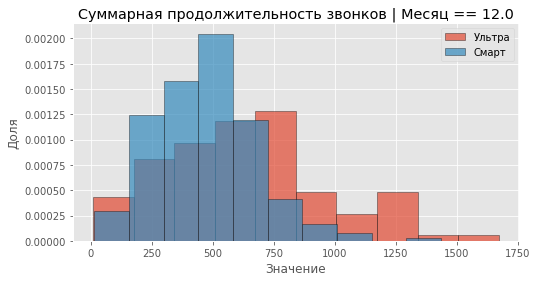

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


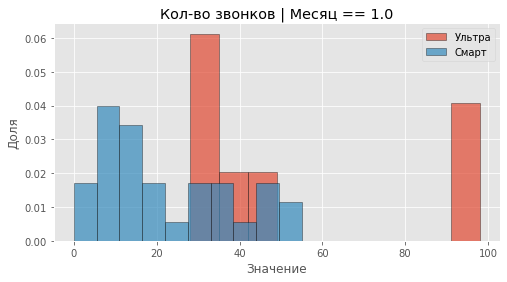

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')


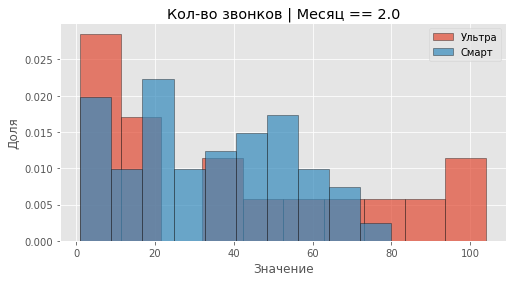

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


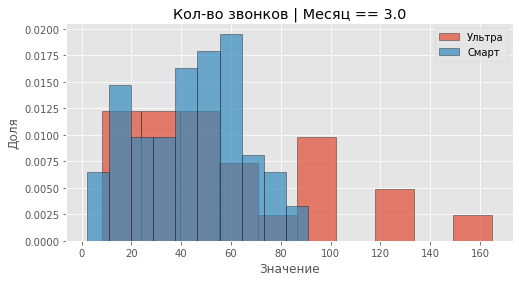

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


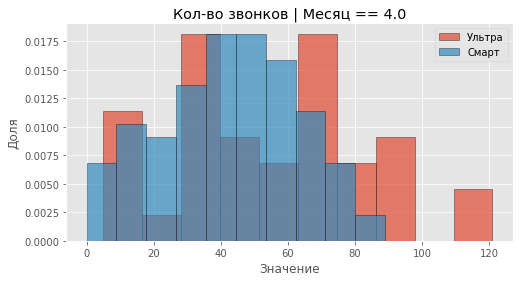

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


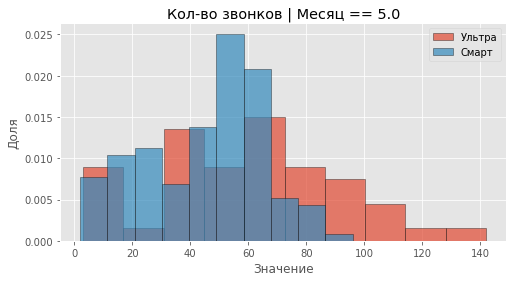

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


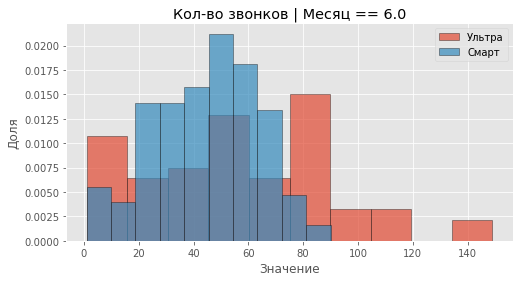

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


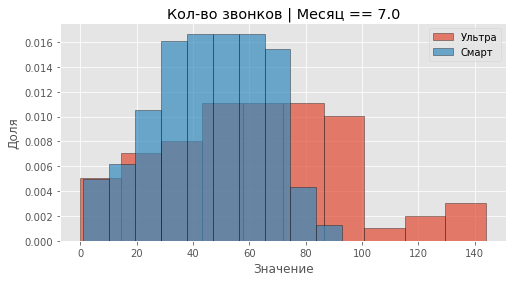

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


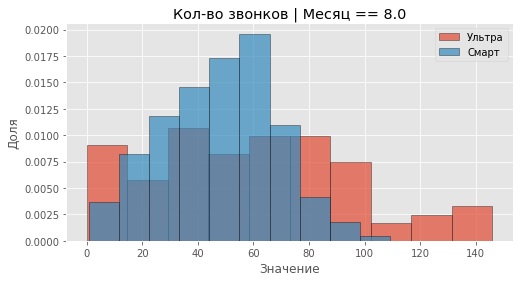

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


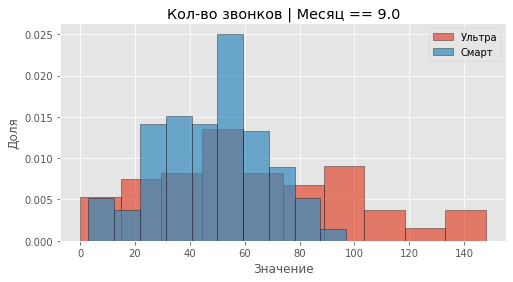

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


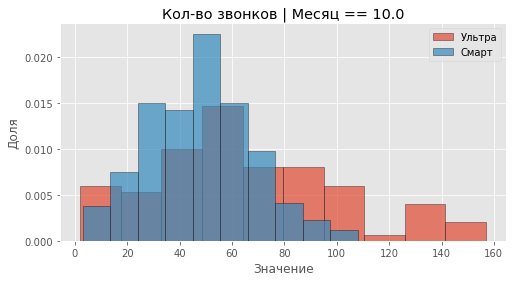

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


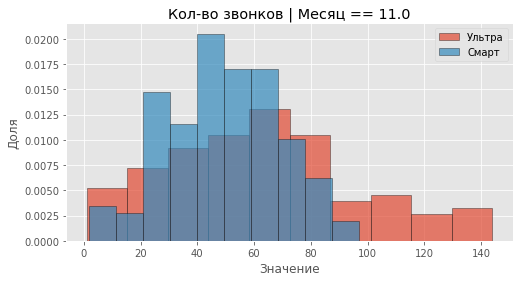

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


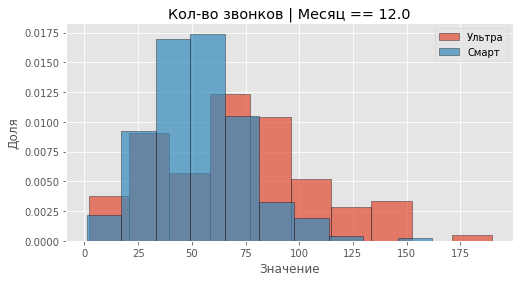

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


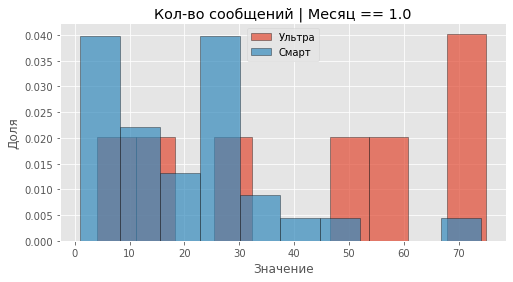

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


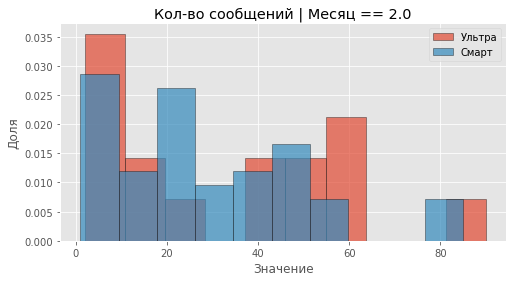

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


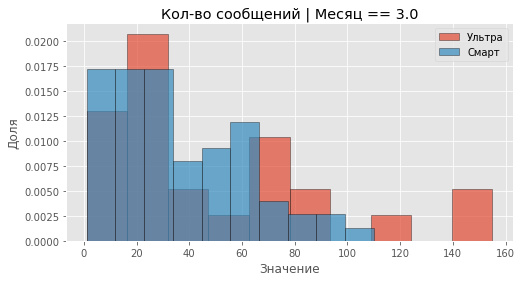

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


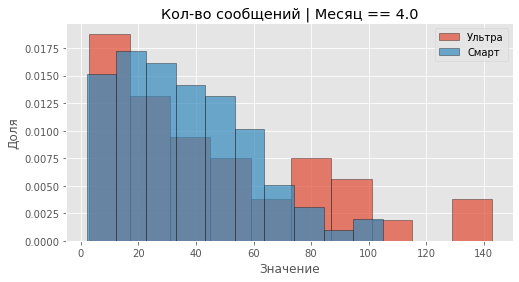

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


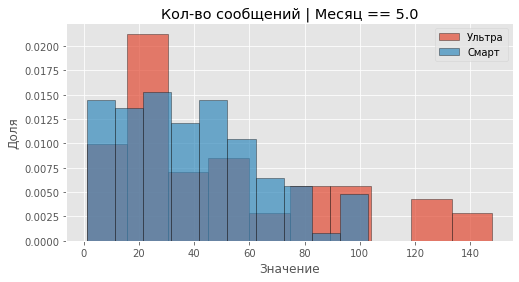

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


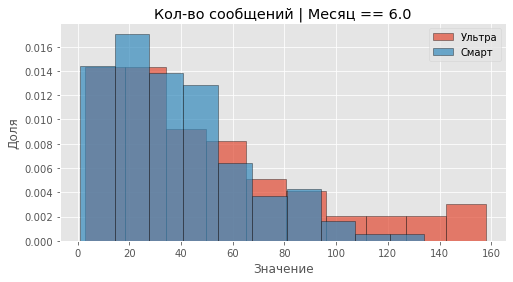

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


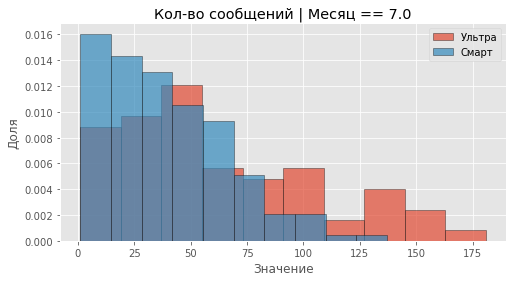

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


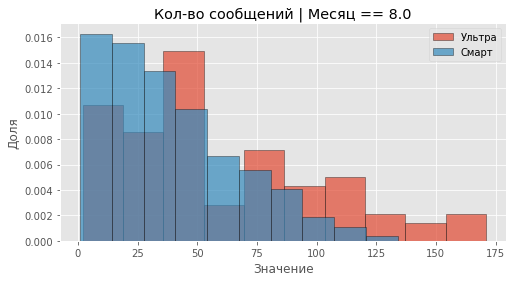

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


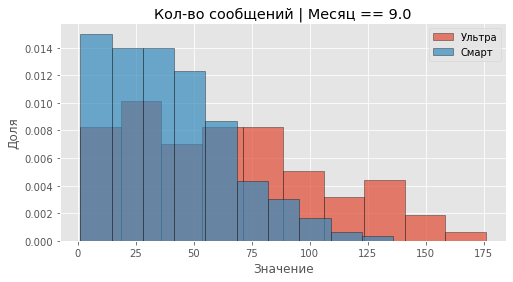

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


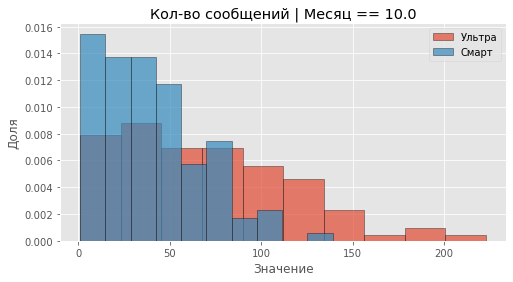

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


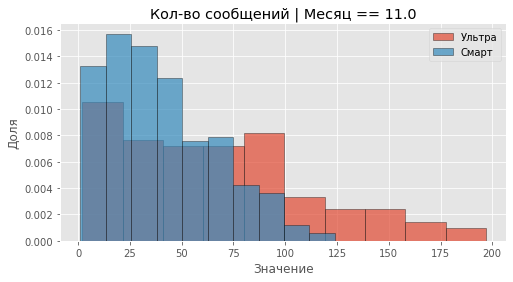

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


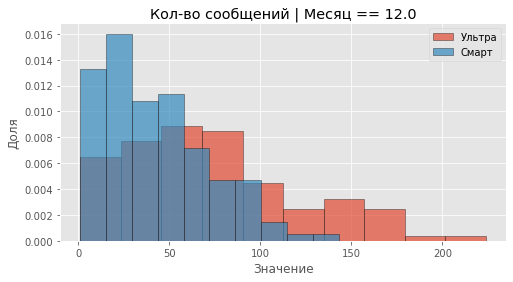

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')


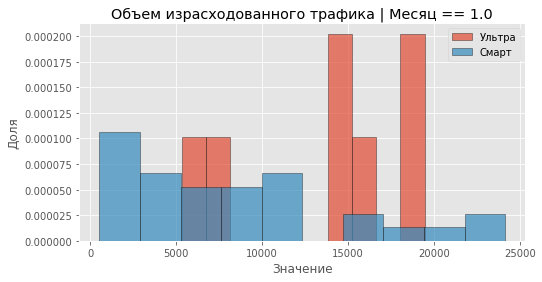

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


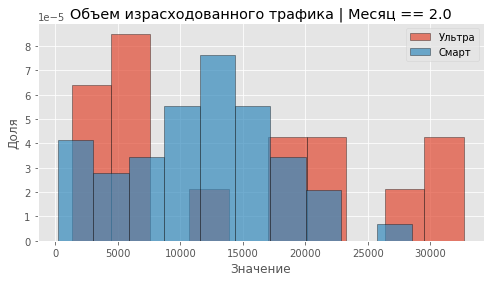

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')


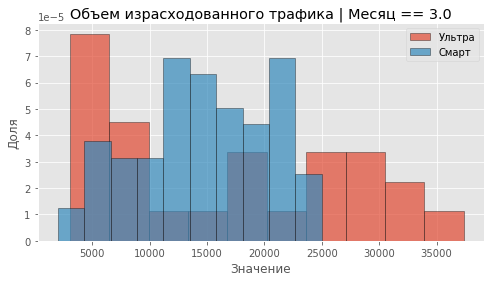

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Равномерное | Принимаем')


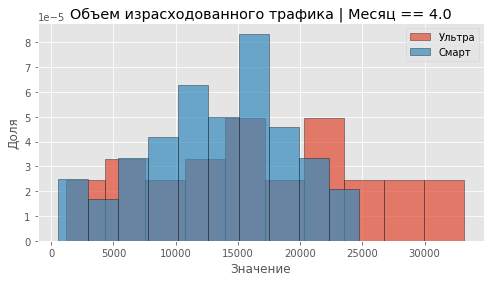

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


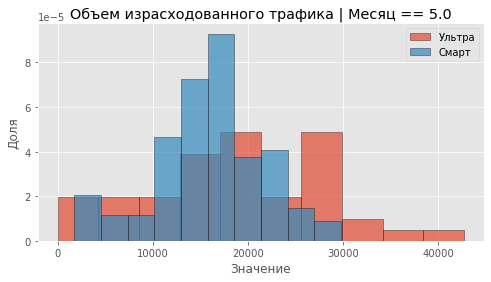

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


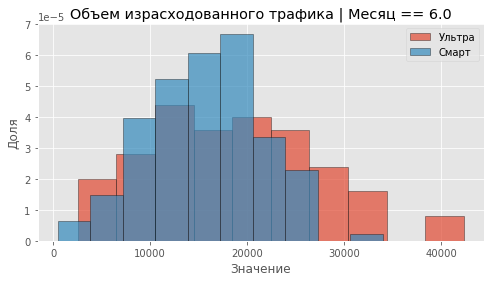

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


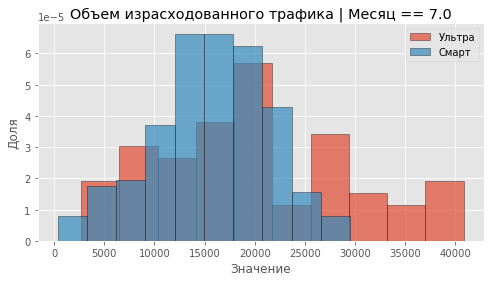

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


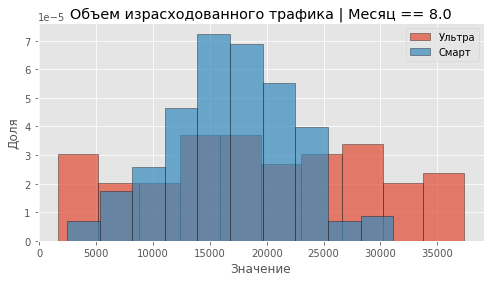

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Равномерное | Принимаем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


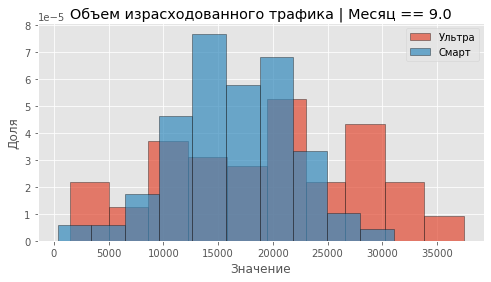

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


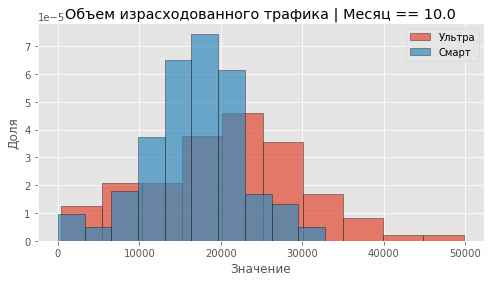

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


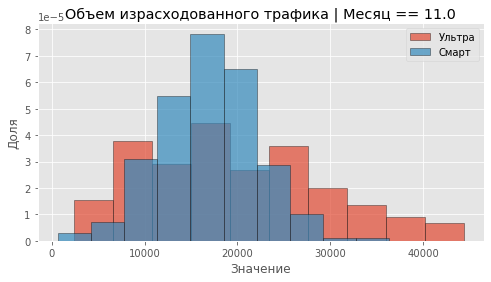

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


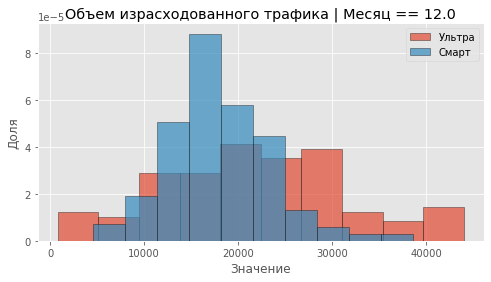

Ультра
('Нормалбьное | Принимаем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


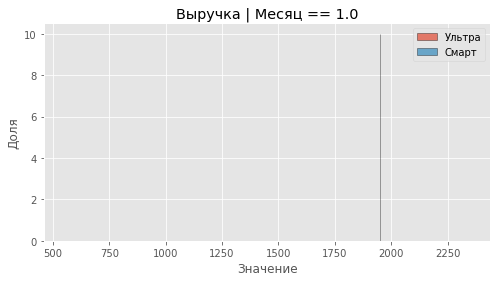

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


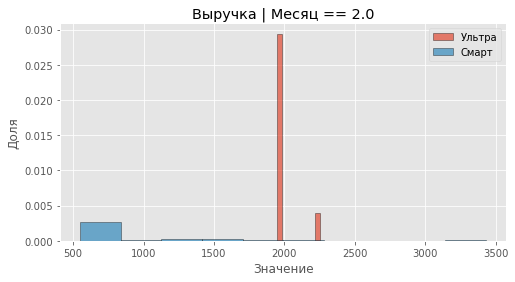

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


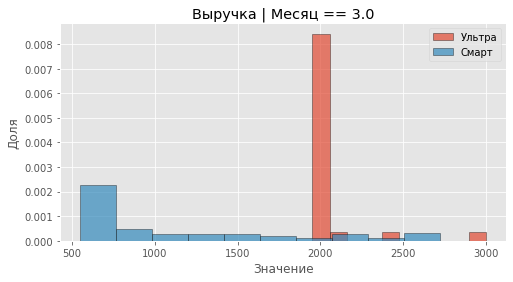

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


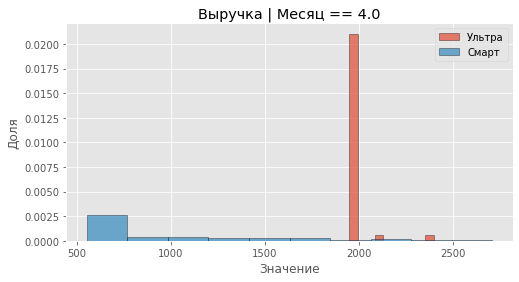

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


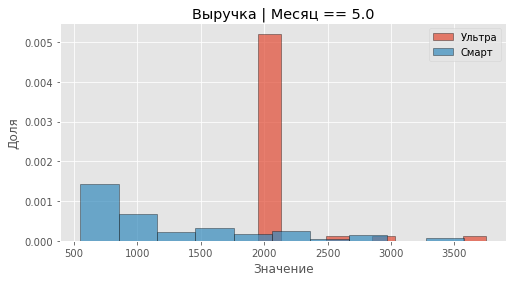

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


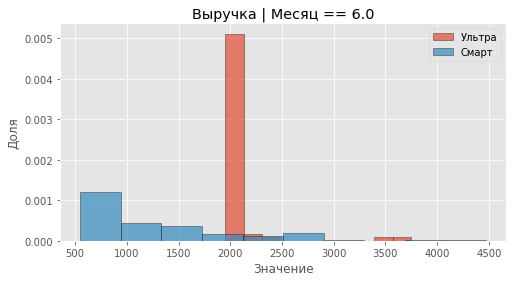

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


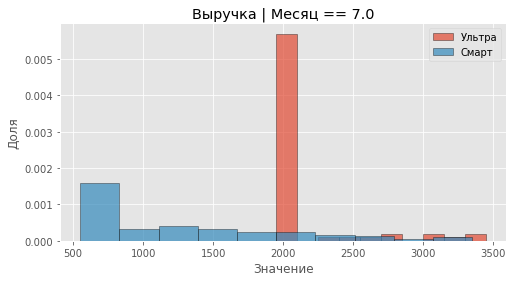

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


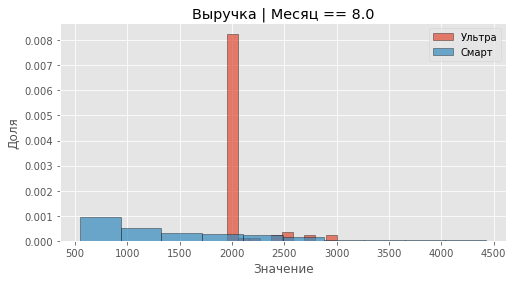

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


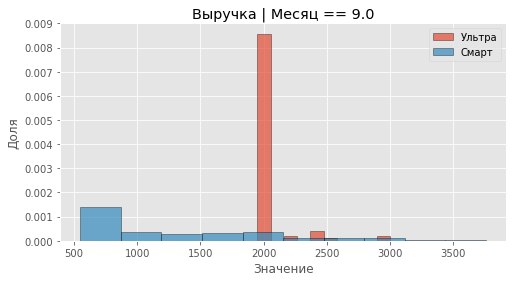

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


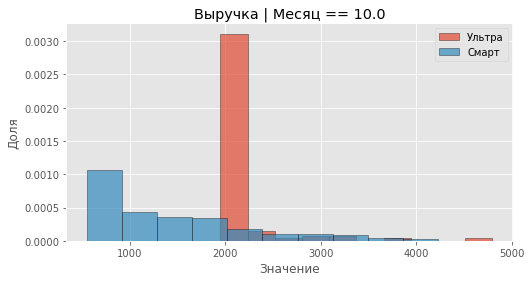

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


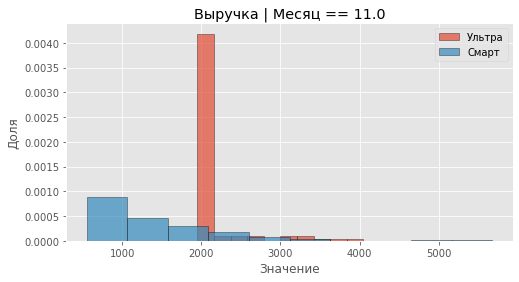

Ультра
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')
Смарт
('Нормалбьное | Отклоняем', 'Логнормальное | Отклоняем', 'Раномерное | Отклоняем')


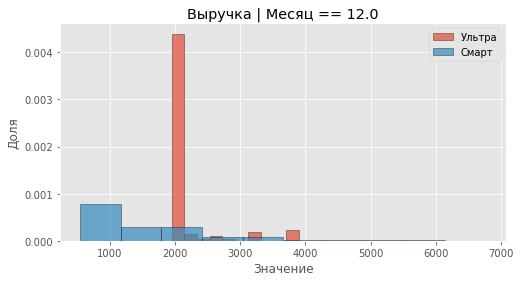

In [36]:
res = []
mask1 = df_monthly_by_tariff['Тариф'] == 'Ультра'
for col in ['Суммарная продолжительность звонков',
       'Кол-во звонков', 'Кол-во сообщений', 'Объем израсходованного трафика',
       'Выручка']:

    for month in np.unique(df_monthly_by_tariff['Месяц']):       
        
        ax = plt.subplot(1, 1, 1)
        dist1 = df_monthly_by_tariff[mask & (df_monthly_by_tariff['Месяц'] == month)][col]
        dist1.hist(density = 1, alpha = .7, ax = ax, edgecolor = 'black', figsize = (8, 4))
        print('Ультра')
        print(_test_distribution(dist1, alpha=.05))

        dist2 = df_monthly_by_tariff[~mask & (df_monthly_by_tariff['Месяц'] == month)][col]
        dist2.hist(density = 1, alpha = .7, ax = ax, edgecolor = 'black', figsize = (8, 4))
        print('Смарт')
        print(_test_distribution(dist2, alpha=.05))

        plt.title(col + ' | Месяц == {}'.format(month))
        plt.xlabel('Значение')
        plt.ylabel('Доля')    
        plt.legend(['Ультра', 'Смарт'])
        plt.show() 
        
        res.append((col, month, 'Ультра', _test_distribution(dist2, alpha=.05)))
        res.append((col, month, 'Смарт', _test_distribution(dist1, alpha=.05)))

In [37]:
_rep =pd.DataFrame.from_records(res)
_rep.columns = ['Показатель', 'Месяц', 'Тариф', 'Гипотезы о распределении']

In [38]:
res_d = defaultdict(list)
for i in _rep.index:
    res_d[_rep.loc[i, 'Гипотезы о распределении']].append((_rep.loc[i, 'Показатель'], _rep.loc[i, 'Месяц'],_rep.loc[i, 'Тариф'] ))

In [39]:
print('Распределения по месяцам')
for k, v in res_d.items():
    print(k)
    for j, element in enumerate(v):
        print('\t{}, показатель == {}, месяц == {}, тариф == {}'.format(j, element[0], element[1],element[2]))
    print('--------------------------------------')

Распределения по месяцам
('Нормалбьное | Принимаем', 'Логнормальное | Принимаем', 'Раномерное | Отклоняем')
	0, показатель == Суммарная продолжительность звонков, месяц == 1.0, тариф == Ультра
	1, показатель == Суммарная продолжительность звонков, месяц == 1.0, тариф == Смарт
	2, показатель == Суммарная продолжительность звонков, месяц == 3.0, тариф == Смарт
	3, показатель == Суммарная продолжительность звонков, месяц == 5.0, тариф == Смарт
	4, показатель == Суммарная продолжительность звонков, месяц == 7.0, тариф == Смарт
	5, показатель == Суммарная продолжительность звонков, месяц == 9.0, тариф == Смарт
	6, показатель == Кол-во звонков, месяц == 1.0, тариф == Ультра
	7, показатель == Кол-во звонков, месяц == 1.0, тариф == Смарт
	8, показатель == Кол-во звонков, месяц == 3.0, тариф == Смарт
	9, показатель == Кол-во звонков, месяц == 7.0, тариф == Смарт
	10, показатель == Кол-во звонков, месяц == 8.0, тариф == Смарт
	11, показатель == Кол-во звонков, месяц == 9.0, тариф == Смарт
	12, п

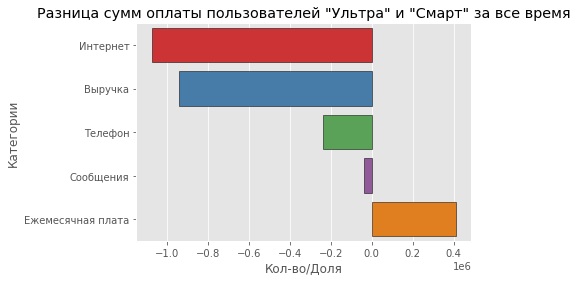

In [40]:
payments_by_tariff = df_total_report.groupby('Тариф')[payments].sum().T
payments_by_tariff['Ультра-Смарт'] = payments_by_tariff['Ультра'] - payments_by_tariff['Смарт']
                   
_plot_bar(payments_by_tariff['Ультра-Смарт'].sort_values(), True, 'Разница сумм оплаты пользователей "Ультра" и "Смарт" за все время')

In [41]:
agg_by_tariff_month = pd.merge(df_montly_by_user, df_user[['tariff', 'user_id']], on = 'user_id')\
                        .drop('user_id', 1)\
                        .rename(columns = {'tariff': 'Тариф'})\
                        .groupby(['Тариф', 'Месяц'])\
                            [
                             ['Суммарная продолжительность звонков', 'Кол-во звонков',\
                              'Кол-во сообщений', 'Объем израсходованного трафика']
                            ].agg({'sum', 'mean', 'count', 'std', 'var'})

In [42]:
agg_by_tariff_month 

Суммарная продолжительность звонков                        \
                                            var        mean       sum   
Тариф Месяц                                                             
smart 1                            24412.951613  204.875000    6556.0   
      2                            38223.130196  307.568627   15686.0   
      3                            38040.933504  393.086957   27123.0   
      4                            34940.163265  376.000000   37224.0   
      5                            34755.317606  396.837398   48811.0   
      6                            29587.407663  396.335664   56676.0   
      7                            31646.184123  408.710227   71933.0   
      8                            34482.391406  427.591133   86801.0   
      9                            32485.217778  426.808889   96032.0   
      10                           34427.128645  426.192913  108253.0   
      11                           30817.005427  437.294118  118944.0   
      12                           40461.149870  473.712803  136903.0   
ultra 1                            70909.000000  476.000000    3332.0   
      2                           100166.867647  359.352941    6109.0   
      3                           137892.984615  536.769231   13956.0   
      4                            73225.775960  499.815789   18993.0   
      5                            82362.877660  532.125000   25542.0   
      6                            96847.023041  497.761905   31359.0   
      7                            90955.543478  558.565217   38541.0   
      8                            97084.594475  527.493976   43782.0   
      9                            98498.784519  564.844444   50836.0   
      10                          102019.751718  577.092784   55978.0   
      11                           89614.339799  560.289720   59951.0   
      12                          106507.709701  634.544643   71069.0   

                              Кол-во звонков                               \
                    std count            var       mean    sum        std   
Тариф Месяц                                                                 
smart 1      156.246445    32     258.918347  21.718750    695  16.090940   
      2      195.507366    51     461.094902  33.843137   1726  21.473120   
      3      195.040851    69     449.462916  44.086957   3042  21.200540   
      4      186.922881    99     432.848691  42.373737   4195  20.805016   
      5      186.427781   123     438.689058  45.154472   5554  20.944905   
      6      172.009906   143     360.629272  44.552448   6371  18.990241   
      7      177.893744   176     396.421688  45.784091   8058  19.910341   
      8      185.694349   203     413.541043  47.940887   9732  20.335709   
      9      180.236561   225     386.104643  47.773333  10749  19.649546   
      10     185.545489   254     402.110859  47.692913  12114  20.052702   
      11     175.547730   272     373.483598  49.290441  13407  19.325724   
      12     201.149571   289     496.118056  53.294118  15402  22.273708   
ultra 1      266.287439     7     962.238095  52.285714    366  31.019963   
      2      316.491497    17    1248.735294  40.882353    695  35.337449   
      3      371.339447    26    1600.506154  59.115385   1537  40.006326   
      4      270.602616    38     850.563300  56.368421   2142  29.164418   
      5      286.989334    48    1040.584663  60.395833   2899  32.258095   
      6      311.202543    63    1138.929852  56.317460   3548  33.748035   
      7      301.588368    69    1126.783035  63.159420   4358  33.567589   
      8      311.584009    83    1261.830444  59.216867   4915  35.522253   
      9      313.845160    90    1244.669663  63.400000   5706  35.279876   
      10     319.405309    97    1287.937285  65.144330   6319  35.887843   
      11     299.356543   107    1138.889614  62.841121   6724  33.747439   
      12     326.355189   112    1369.

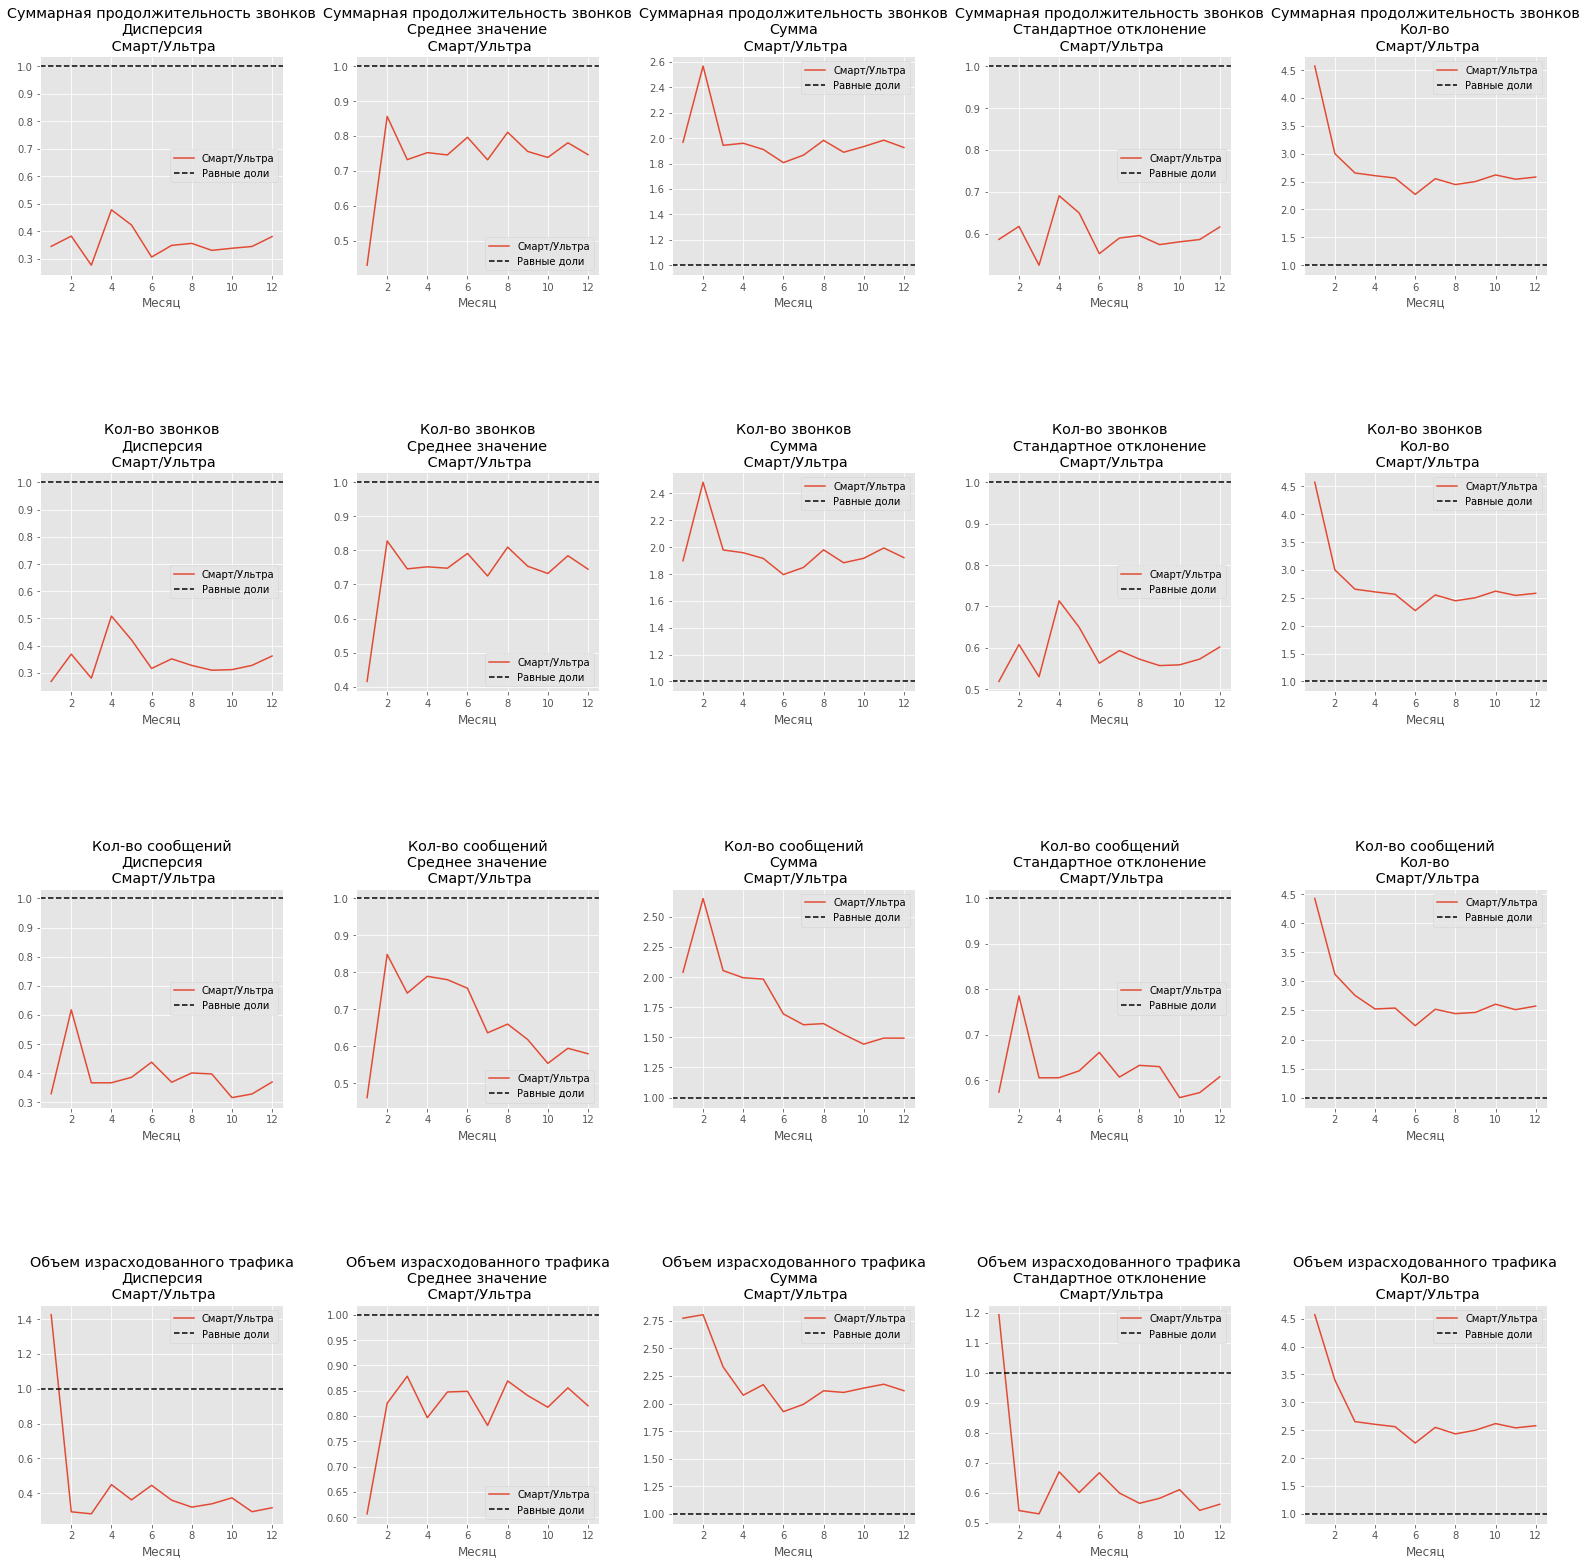

In [43]:
report_df = pd.DataFrame()
i = 0
for col1 in agg_by_tariff_month.columns.levels[0]:
    
    agg = agg_by_tariff_month[col1].rename(columns = {'mean' : 'Среднее значение',\
                                                     'var' : 'Дисперсия',\
                                                     'sum' : 'Сумма',\
                                                     'count' : 'Кол-во',
                                                     'std': 'Стандартное отклонение'})
    for col2 in agg.columns:  
        ax = plt.subplot(4, 5, i+1)        
        plt.title(col1 + '\n' + col2 +'\n Смарт/Ультра')
        _subdf = agg[col2].unstack(0)
        diff = _subdf['smart'] / _subdf['ultra']  
        diff.plot(ax = ax, figsize = (27, 27))
        plt.axhline(1, color = 'black', linestyle = '--')
        plt.legend(['Смарт/Ультра', 'Равные доли'])
        i+=1
        
        colname = ' | '.join([col1, col2])
        for k, v in diff.items():
            report_df.loc[colname+ ' | месяц == {}'.format(k), 'Смарт/Ультра'] = v
    
plt.subplots_adjust(wspace = .3, hspace = .9)    

* "Смарт" расходует меньше трафика
* разброс значений у пользователей "Смарт" меньше
* в сумме тариф "Смарт" приносит больше дохода
* Тариф имеет распределение бернулли, остальные признаки - произваольные распределения


In [44]:
report_df = report_df.sort_values('Смарт/Ультра', ascending = False).round(1)

D_diff_groups = {}
for _share, _subdf in report_df.groupby('Смарт/Ультра'):
    D_diff_groups[_share] = _subdf.index.tolist()

print('-------------------------------ВЫВОДЫ-------------------------------\n')
for k, v in pd.Series(D_diff_groups).sort_index().items():    
    print('Смарт / Ультра  == {}'.format(k))
    
    for idx, element in enumerate(v):
        print('\t{} {}'.format(str(idx+1), str(element)))
    print('----------------------------------')
        

-------------------------------ВЫВОДЫ-------------------------------

Смарт / Ультра  == 0.3
	1 Суммарная продолжительность звонков | Дисперсия | месяц == 7
	2 Суммарная продолжительность звонков | Дисперсия | месяц == 1
	3 Суммарная продолжительность звонков | Дисперсия | месяц == 11
	4 Объем израсходованного трафика | Дисперсия | месяц == 9
	5 Суммарная продолжительность звонков | Дисперсия | месяц == 10
	6 Суммарная продолжительность звонков | Дисперсия | месяц == 9
	7 Кол-во сообщений | Дисперсия | месяц == 1
	8 Кол-во сообщений | Дисперсия | месяц == 11
	9 Кол-во звонков | Дисперсия | месяц == 11
	10 Кол-во звонков | Дисперсия | месяц == 8
	11 Объем израсходованного трафика | Дисперсия | месяц == 8
	12 Кол-во звонков | Дисперсия | месяц == 6
	13 Кол-во сообщений | Дисперсия | месяц == 10
	14 Объем израсходованного трафика | Дисперсия | месяц == 12
	15 Кол-во звонков | Дисперсия | месяц == 10
	16 Кол-во звонков | Дисперсия | месяц == 9
	17 Суммарная продолжительность звонков | Дисп

## Шаг 4. Проверьте гипотезы
* для применяется критерий стьюдента, если распределения величин нормальные
* для долей применяется критерий Стьюдента
* если распределение величин другое, то применяется бутстреп
* H0 : нулеавя гипотеза - равенство средних в двух выборках
* H1 : альтернативная - неравенство
* уровень значимсоти - вероятность ошибки первого рода для H0

In [45]:
alpha = .05
for payment in payments:
    test_result = _compare_means_in_two_groups(df_total_report, by = 'Тариф', to_compare = payment, alpha =alpha)[0]
    print('Средние значения в {} у тарифов {} и {} {} на уровне значимости {:.0%}'\
              .format(str.upper(payment), test_result[0], test_result[1], test_result[2], 1-alpha))

Средние значения в ЕЖЕМЕСЯЧНАЯ ПЛАТА у тарифов Смарт и Ультра Разные на уровне значимости 95%
Средние значения в ТЕЛЕФОН у тарифов Смарт и Ультра Одинаковые на уровне значимости 95%
Средние значения в ИНТЕРНЕТ у тарифов Смарт и Ультра Одинаковые на уровне значимости 95%
Средние значения в СООБЩЕНИЯ у тарифов Смарт и Ультра Одинаковые на уровне значимости 95%
Средние значения в ВЫРУЧКА у тарифов Смарт и Ультра Разные на уровне значимости 95%


Средние значения выручки в Москва и Регионы Одинаковые на уровне значимости 95%


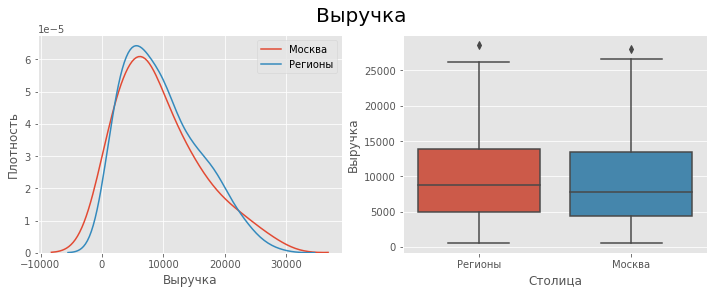

In [46]:
df_total_report['Столица'] = df_total_report['Город'].apply(lambda x: x if x == 'Москва' else 'Регионы')
moscow_reg = _compare_means_in_two_groups(df_total_report, by = 'Столица', to_compare = 'Выручка', alpha =alpha)[0]
print('Средние значения выручки в {} и {} {} на уровне значимости {:.0%}'\
      .format(moscow_reg[0], moscow_reg[1], moscow_reg[2], 1-alpha))
_plot_kde_boxplot_by_category(df_total_report, by = 'Столица', to_compare = 'Выручка', figsize = (12, 4))